## Model RoBERTa

In [1]:
import pandas as pd
import torch

In [2]:
dataset = pd.read_csv("data/dataset_topics.csv")
dataset

,text,labels,id,author,subreddit,created_utc,cluster,topic
0,My favourite food is anything I didn't have to...,[27],eebbqej,Rockzilla78,KitchenConfidential,2019-01-18,1,other
1,"Now if he does off himself, everyone will thin...",[27],ed00q6i,cocaineluna,morbidquestions,2019-01-01,0,humor
2,WHY THE FUCK IS BAYLESS ISOING,[2],eezlygj,minnesotagoat_,timberwolves,2019-01-26,2,sport
3,To make her feel threatened,[14],ed7ypvh,AlexNic1013,askwomenadvice,2019-01-04,4,love and relationship
4,Dirty Southern Wankers,[3],ed0bdzj,having_a_nap,london,2019-01-01,1,other
...,...,...,...,...,...,...,...,...
54258,Thanks. I was diagnosed with BP 1 after the ho...,[15],efeeasc,scaredyk4t,bipolar,2019-01-30,4,love and relationship
54259,Well that makes sense.,[4],ef9c7s3,LX_Emergency,ABoringDystopia,2019-01-29,3,politics
54260,Daddy issues [NAME],[27],efbiugo,your_ex_girlfriend-,SquaredCircle,2019-01-30,5,film and TV series
54261,So glad I discovered that subreddit a couple m...,[0],efbvgp9,Paladin-Arda,AskALiberal,2019-01-30,3,politics


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

Device: cuda


### Preprocessing

I convert each `dataset['labels']` into a fixed-lenght 0/1 vector beacuse:
1. multi-label encoding
    + we have a list like `[2, 14, 27]` that tells us which classes are present, a multi-hot vector of lenght 28 `[0,0,1,0,...,1]` tells us which of the 28 possible emotions are active (1) or inactive (0) in a tensor
2. Model expectation
    + In Hugging Face's `problem_type="multi_label_classification"` the model uses a binary-cross-entropy loss with logits. That loss requires, for each example, a float tensor of shape `[num_labels]` with 0.0/1.0 targets, not a list of indices
3. Clear interpretation and metric calculation
    + Post-inference we'll get model outputs of shape `[batch_size, 28]`

In [4]:
import re

In [5]:
type(dataset['labels'][0])

str

In [6]:
def parse_label(label):
    nums = re.findall(r'\d+', label)
    return [int(n) for n in nums]

dataset['labels'] = dataset['labels'].apply(parse_label)

In [7]:
type(dataset['labels'][0])

list

In [8]:
def convert_labels_to_multihot(l):
    vec = [0] * 28
    for idx in l:
        vec[idx] = 1
    return vec

dataset['labels_multihot'] = dataset['labels'].apply(convert_labels_to_multihot)

In [9]:
dataset

,text,labels,id,author,subreddit,created_utc,cluster,topic,labels_multihot
0,My favourite food is anything I didn't have to...,[27],eebbqej,Rockzilla78,KitchenConfidential,2019-01-18,1,other,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,"Now if he does off himself, everyone will thin...",[27],ed00q6i,cocaineluna,morbidquestions,2019-01-01,0,humor,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,WHY THE FUCK IS BAYLESS ISOING,[2],eezlygj,minnesotagoat_,timberwolves,2019-01-26,2,sport,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,To make her feel threatened,[14],ed7ypvh,AlexNic1013,askwomenadvice,2019-01-04,4,love and relationship,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."
4,Dirty Southern Wankers,[3],ed0bdzj,having_a_nap,london,2019-01-01,1,other,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...,...,...,...,...
54258,Thanks. I was diagnosed with BP 1 after the ho...,[15],efeeasc,scaredyk4t,bipolar,2019-01-30,4,love and relationship,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
54259,Well that makes sense.,[4],ef9c7s3,LX_Emergency,ABoringDystopia,2019-01-29,3,politics,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
54260,Daddy issues [NAME],[27],efbiugo,your_ex_girlfriend-,SquaredCircle,2019-01-30,5,film and TV series,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
54261,So glad I discovered that subreddit a couple m...,[0],efbvgp9,Paladin-Arda,AskALiberal,2019-01-30,3,politics,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [10]:
label = dataset['labels'][0]
multi_hot = dataset['labels_multihot'][0]

print(f"label = {label}")
print(f"label multi-hot = {multi_hot}")

label = [27]
label multi-hot = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]


In [11]:
dataset = dataset.drop(columns=['labels'])

In [12]:
dataset = dataset.rename(columns={'labels_multihot': 'labels'})

In [13]:
dataset.columns

Index(['text', 'id', 'author', 'subreddit', 'created_utc', 'cluster', 'topic',
       'labels'],
      dtype='object')

### Train-Validation-Test split

In [14]:
from sklearn.model_selection import train_test_split
from collections import Counter

In [15]:
X = dataset.drop(columns=['labels'])
y = dataset['labels']

# split train-test
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, 
    test_size=5427, 
    random_state=42)

# split train-validation
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, 
    test_size=5426, 
    random_state=42)

In [16]:
print(f"Length training set = {len(X_train)}")
print(f"Length validation set = {len(X_val)}")
print(f"Length testing set = {len(X_test)}")

Length training set = 43410
Length validation set = 5426
Length testing set = 5427


### Tokenization

In [17]:
from transformers import AutoTokenizer

/home/biso/Uni/corsi/uni_venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [18]:
model_name = "roberta-base"

tokenizer = AutoTokenizer.from_pretrained(model_name)

train_encodings = tokenizer(
    list(X_train['text']),
    truncation=True,
    padding="max_length",
    max_length=128,
    return_tensors="pt"
)

val_encodings = tokenizer(
    list(X_val['text']),
    truncation=True,
    padding="max_length",
    max_length=128,
    return_tensors="pt" 
)

test_encodings = tokenizer(
    list(X_test['text']),
    truncation=True,
    padding="max_length",
    max_length=128,
    return_tensors="pt"
)

In [19]:
idx = 0

# original
print(f"Original: {X_train.iloc[idx]['text']}")

print("---------------------------------")

# token_id and attention mask
print(f"Token IDs: {train_encodings['input_ids'][idx][:10]}")
print(f"Attention mask: {train_encodings['attention_mask'][idx][:10]}")

print("---------------------------------")

# show tokens
tokens = tokenizer.convert_ids_to_tokens(train_encodings['input_ids'][idx])
print(f"Tokenized: {tokens[:10]}")

Original: Hahaha exactly, and deciding on even the most simple of things
---------------------------------
Token IDs: tensor([    0,   725,   895, 11695,  2230,     6,     8,  8997,    15,   190])
Attention mask: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
---------------------------------
Tokenized: ['<s>', 'H', 'ah', 'aha', 'Ġexactly', ',', 'Ġand', 'Ġdeciding', 'Ġon', 'Ġeven']


### Model 

In [20]:
from transformers import AutoConfig
from transformers import AutoModelForSequenceClassification
import json

In [21]:
emotions = [
    "admiration", "amusement", "anger", "annoyance", "approval",
    "caring", "confusion", "curiosity", "desire", "disappointment",
    "disapproval", "disgust", "embarrassment", "excitement", "fear",
    "gratitude", "grief", "joy", "love", "nervousness", "optimism",
    "pride", "realization", "relief", "remorse", "sadness", "surprise", "neutral"
]

label2id = {name: idx for idx, name in enumerate(emotions)}
id2label = {idx: name for name, idx in label2id.items()}

config = AutoConfig.from_pretrained(model_name)
config.num_labels = len(emotions)
config.problem_type = "multi_label_classification"
config.id2label = id2label
config.label2id = label2id

model = AutoModelForSequenceClassification.from_pretrained(model_name, config=config)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [22]:
print(f"Problem type: {model.config.problem_type}")

Problem type: multi_label_classification


In [23]:
print(json.dumps(model.config.to_dict(), indent=4))

{
    "return_dict": true,
    "output_hidden_states": false,
    "output_attentions": false,
    "torchscript": false,
    "torch_dtype": "float32",
    "use_bfloat16": false,
    "tf_legacy_loss": false,
    "pruned_heads": {},
    "tie_word_embeddings": true,
    "chunk_size_feed_forward": 0,
    "is_encoder_decoder": false,
    "is_decoder": false,
    "cross_attention_hidden_size": null,
    "add_cross_attention": false,
    "tie_encoder_decoder": false,
    "max_length": 20,
    "min_length": 0,
    "do_sample": false,
    "early_stopping": false,
    "num_beams": 1,
    "num_beam_groups": 1,
    "diversity_penalty": 0.0,
    "temperature": 1.0,
    "top_k": 50,
    "top_p": 1.0,
    "typical_p": 1.0,
    "repetition_penalty": 1.0,
    "length_penalty": 1.0,
    "no_repeat_ngram_size": 0,
    "encoder_no_repeat_ngram_size": 0,
    "bad_words_ids": null,
    "num_return_sequences": 1,
    "output_scores": false,
    "return_dict_in_generate": false,
    "forced_bos_token_id": null

In [24]:
print(f"Number of labels: {model.config.num_labels}")
print("--------------------------------------------")
map_labels = model.config.id2label
for idx in sorted(map_labels.keys()):
    print(f"Index {idx} -> {map_labels[idx]}")

Number of labels: 28
--------------------------------------------
Index 0 -> admiration
Index 1 -> amusement
Index 2 -> anger
Index 3 -> annoyance
Index 4 -> approval
Index 5 -> caring
Index 6 -> confusion
Index 7 -> curiosity
Index 8 -> desire
Index 9 -> disappointment
Index 10 -> disapproval
Index 11 -> disgust
Index 12 -> embarrassment
Index 13 -> excitement
Index 14 -> fear
Index 15 -> gratitude
Index 16 -> grief
Index 17 -> joy
Index 18 -> love
Index 19 -> nervousness
Index 20 -> optimism
Index 21 -> pride
Index 22 -> realization
Index 23 -> relief
Index 24 -> remorse
Index 25 -> sadness
Index 26 -> surprise
Index 27 -> neutral


In [25]:
from torch.optim import AdamW
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import os
import torch.nn as nn

In [26]:
class EmotionDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = list(labels)
    
    def __getitem__(self, index):
        item = {key: value[index] for key, value in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[index])
        return item
    
    def __len__(self):
        return len(self.labels)

In [27]:
train_dataset = EmotionDataset(train_encodings, y_train)
val_dataset = EmotionDataset(val_encodings, y_val)
test_dataset = EmotionDataset(test_encodings, y_test)

In [28]:
for i in range(3):
    example = train_dataset[i]
    print(f"\nSample {i}")
    print(f"Tokens: {tokenizer.convert_ids_to_tokens(example['input_ids'][:10])}")
    print(f"Label: {example['labels']}")


Sample 0
Tokens: ['<s>', 'H', 'ah', 'aha', 'Ġexactly', ',', 'Ġand', 'Ġdeciding', 'Ġon', 'Ġeven']
Label: tensor([0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0])

Sample 1
Tokens: ['<s>', 'Sweet', 'Ġthanks', 'Ġfor', 'Ġthe', 'Ġupdate', '.', 'ĠI', 'Ġhope', 'Ġthe']
Label: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
        0, 0, 0, 0])

Sample 2
Tokens: ['<s>', 'Science', 'Ġis', 'Ġmeasuring', 'Ġwhat', 'Ġwe', 'Ġsee', '.', 'ĠI', 'Ġalso']
Label: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 1])


In [29]:
save_path = "./best_model_RoBERTa"

In [71]:
model.to(device)

train_batch_size = 16
val_batch_size = 64
n_epochs = 4
learning_rate = 2e-5

# dataloader
train_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=val_batch_size)

optimizer = AdamW(model.parameters(), lr=learning_rate)

best_f1 = 0.0
os.makedirs(save_path, exist_ok=True)

loss_fn = nn.BCEWithLogitsLoss()

for epoch in range(n_epochs):
    model.train()
    total_loss = 0

    print(f"\n Epoch {epoch+1}/{n_epochs}")

    for batch in tqdm(train_loader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device).float()

        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        loss = loss_fn(logits, labels)

        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_train_loss = total_loss/len(train_loader)
    print(f"✅ Training Loss: {avg_train_loss:.4f}")

    # -- validation --
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device).float()
            
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            preds = (torch.sigmoid(logits) >= 0.5).int()

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    print(f"Validation accuracy = {accuracy:4f} | F1 score = {f1:4f}")

    if f1 > best_f1:
        best_f1 = f1
        model.save_pretrained(save_path)

tokenizer.save_pretrained(save_path)
print(f"✅ Modello e tokenizer salvati in: {save_path}")


 Epoch 1/4


100%|██████████| 2714/2714 [10:25<00:00,  4.34it/s]


✅ Training Loss: 0.1204
Validation accuracy = 0.393107 | F1 score = 0.471962

 Epoch 2/4


100%|██████████| 2714/2714 [10:27<00:00,  4.32it/s]


✅ Training Loss: 0.0857
Validation accuracy = 0.422595 | F1 score = 0.521836

 Epoch 3/4


100%|██████████| 2714/2714 [10:26<00:00,  4.33it/s]


✅ Training Loss: 0.0760
Validation accuracy = 0.447107 | F1 score = 0.546674

 Epoch 4/4


100%|██████████| 2714/2714 [10:26<00:00,  4.33it/s]


✅ Training Loss: 0.0679
Validation accuracy = 0.459454 | F1 score = 0.557044
✅ Modello e tokenizer salvati in: ./best_model_RoBERTa


### Testing

In [30]:
from sklearn.metrics import precision_recall_fscore_support
import matplotlib.pyplot as plt
import numpy as np 
from collections import Counter

In [31]:
model = AutoModelForSequenceClassification.from_pretrained(save_path).to(device)
tokenizer = AutoTokenizer.from_pretrained(save_path)
model.eval()

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

In [32]:
emotions = [
    "admiration", "amusement", "anger", "annoyance", "approval",
    "caring", "confusion", "curiosity", "desire", "disappointment",
    "disapproval", "disgust", "embarrassment", "excitement", "fear",
    "gratitude", "grief", "joy", "love", "nervousness", "optimism",
    "pride", "realization", "relief", "remorse", "sadness", "surprise", "neutral"
]

In [33]:
test_batch_size = 64
test_loader = DataLoader(test_dataset, batch_size=test_batch_size)

all_logits = []
all_preds = []
all_labels = []
all_probs = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device).int()

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits  # [batch_size, num_labels]

        probs = torch.sigmoid(logits)
        preds = (probs > 0.5).int()

        for i in range(preds.size(0)):
            if preds[i].sum() == 0:
                top_idx = torch.argmax(probs[i]).item()
                preds[i, top_idx] = 1

        all_logits.extend(logits.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)

# test set results
print("\nTest set results:")
print(f"- Accuracy = {accuracy:4f}")
print(f"- Precision = {precision:4f}")
print(f"- Recall = {recall:4f}")
print(f"- F1 score = {f1:4f}")

print("\nClassification report per emotion")
print(classification_report(all_labels, all_preds, target_names=emotions, zero_division=0))


Test set results:
- Accuracy = 0.491985
- Precision = 0.596712
- Recall = 0.545426
- F1 score = 0.561719

Classification report per emotion
                precision    recall  f1-score   support

    admiration       0.67      0.76      0.71       547
     amusement       0.75      0.86      0.80       270
         anger       0.56      0.45      0.50       192
     annoyance       0.37      0.21      0.27       304
      approval       0.45      0.29      0.35       368
        caring       0.35      0.55      0.43       143
     confusion       0.52      0.36      0.43       136
     curiosity       0.46      0.51      0.48       252
        desire       0.55      0.56      0.55        84
disappointment       0.33      0.24      0.28       152
   disapproval       0.44      0.29      0.35       260
       disgust       0.39      0.46      0.42       106
 embarrassment       0.58      0.58      0.58        33
    excitement       0.59      0.39      0.47       105
          fear    

### Show predictions

In [34]:
def print_predictions(idx):
    # logits
    logits_tensor = torch.tensor(all_logits[idx])
    # probability
    probs_tensor = torch.sigmoid(logits_tensor)
    # apply threshold
    preds_tensor = (probs_tensor > 0.5).int()

    if preds_tensor.sum()==0:
        top_idx = torch.argmax(probs_tensor).item()
        preds_tensor[top_idx] = 1

    GREEN = "\033[92m"
    RESET = "\033[0m"

    for i in range(len(preds_tensor)):
        color = GREEN if preds_tensor[i] == 1 else RESET
        print(f"{color}[{i}] {emotions[i]} | Logits: {logits_tensor[i]:.4f} -> Prob: {probs_tensor[i]:.4f}{RESET}")

    # print predictions
    print(f"\nPredictions: {[emotions[i] for i in range(len(preds_tensor)) if preds_tensor[i] == 1]}")

    # original text
    print(f"\nOriginal text: \"{X_test['text'].iloc[idx]}\"")

In [35]:
# example on one sample of the test set
idx = 30

print_predictions(idx)

[0] admiration | Logits: -3.8199 -> Prob: 0.0215
[1] amusement | Logits: -6.6657 -> Prob: 0.0013
[2] anger | Logits: -3.7087 -> Prob: 0.0239
[3] annoyance | Logits: -2.6011 -> Prob: 0.0691
[4] approval | Logits: -4.8901 -> Prob: 0.0075
[5] caring | Logits: -6.6550 -> Prob: 0.0013
[6] confusion | Logits: -5.6507 -> Prob: 0.0035
[7] curiosity | Logits: -5.7104 -> Prob: 0.0033
[8] desire | Logits: -6.0147 -> Prob: 0.0024
[9] disappointment | Logits: -0.5382 -> Prob: 0.3686
[10] disapproval | Logits: -3.4710 -> Prob: 0.0301
[11] disgust | Logits: -0.3801 -> Prob: 0.4061
[12] embarrassment | Logits: -2.6893 -> Prob: 0.0636
[13] excitement | Logits: -6.8307 -> Prob: 0.0011
[14] fear | Logits: -4.9174 -> Prob: 0.0073
[15] gratitude | Logits: -6.9536 -> Prob: 0.0010
[16] grief | Logits: -5.8919 -> Prob: 0.0028
[17] joy | Logits: -6.3344 -> Prob: 0.0018
[18] love | Logits: -5.7282 -> Prob: 0.0032
[19] nervousness | Logits: -5.7118 -> Prob: 0.0033
[20] optimism | Logits: -4.0802 -> Prob: 0.0166


In [36]:
idx = 450

print_predictions(idx)

[0] admiration | Logits: -7.3477 -> Prob: 0.0006
[1] amusement | Logits: -6.1265 -> Prob: 0.0022
[2] anger | Logits: -6.8163 -> Prob: 0.0011
[3] annoyance | Logits: -5.4586 -> Prob: 0.0042
[4] approval | Logits: -3.7938 -> Prob: 0.0220
[5] caring | Logits: -5.0737 -> Prob: 0.0062
[6] confusion | Logits: -6.6603 -> Prob: 0.0013
[7] curiosity | Logits: -6.4976 -> Prob: 0.0015
[8] desire | Logits: -4.3378 -> Prob: 0.0129
[9] disappointment | Logits: -4.7882 -> Prob: 0.0083
[10] disapproval | Logits: -6.3845 -> Prob: 0.0017
[11] disgust | Logits: -6.7226 -> Prob: 0.0012
[12] embarrassment | Logits: -6.7504 -> Prob: 0.0012
[13] excitement | Logits: -4.5615 -> Prob: 0.0103
[14] fear | Logits: -6.6872 -> Prob: 0.0012
[15] gratitude | Logits: -6.6626 -> Prob: 0.0013
[16] grief | Logits: -7.1371 -> Prob: 0.0008
[17] joy | Logits: -5.0718 -> Prob: 0.0062
[18] love | Logits: -6.2874 -> Prob: 0.0019
[19] nervousness | Logits: -6.5852 -> Prob: 0.0014
[20] optimism | Logits: -3.7000 -> Prob: 0.0241


In [37]:
idx = 1001

print_predictions(idx)

[0] admiration | Logits: -4.7074 -> Prob: 0.0089
[1] amusement | Logits: -5.5865 -> Prob: 0.0037
[2] anger | Logits: -6.5241 -> Prob: 0.0015
[3] annoyance | Logits: -5.3029 -> Prob: 0.0050
[4] approval | Logits: 1.2215 -> Prob: 0.7723
[5] caring | Logits: -4.9970 -> Prob: 0.0067
[6] confusion | Logits: -6.1579 -> Prob: 0.0021
[7] curiosity | Logits: -4.8426 -> Prob: 0.0078
[8] desire | Logits: -4.6769 -> Prob: 0.0092
[9] disappointment | Logits: -6.4399 -> Prob: 0.0016
[10] disapproval | Logits: -5.6351 -> Prob: 0.0036
[11] disgust | Logits: -6.5663 -> Prob: 0.0014
[12] embarrassment | Logits: -8.1775 -> Prob: 0.0003
[13] excitement | Logits: -5.4350 -> Prob: 0.0043
[14] fear | Logits: -7.8221 -> Prob: 0.0004
[15] gratitude | Logits: -6.5025 -> Prob: 0.0015
[16] grief | Logits: -8.8729 -> Prob: 0.0001
[17] joy | Logits: -5.7234 -> Prob: 0.0033
[18] love | Logits: -6.1223 -> Prob: 0.0022
[19] nervousness | Logits: -8.3157 -> Prob: 0.0002
[20] optimism | Logits: -1.7159 -> Prob: 0.1524
[

### Metrics

/home/biso/Uni/corsi/uni_venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


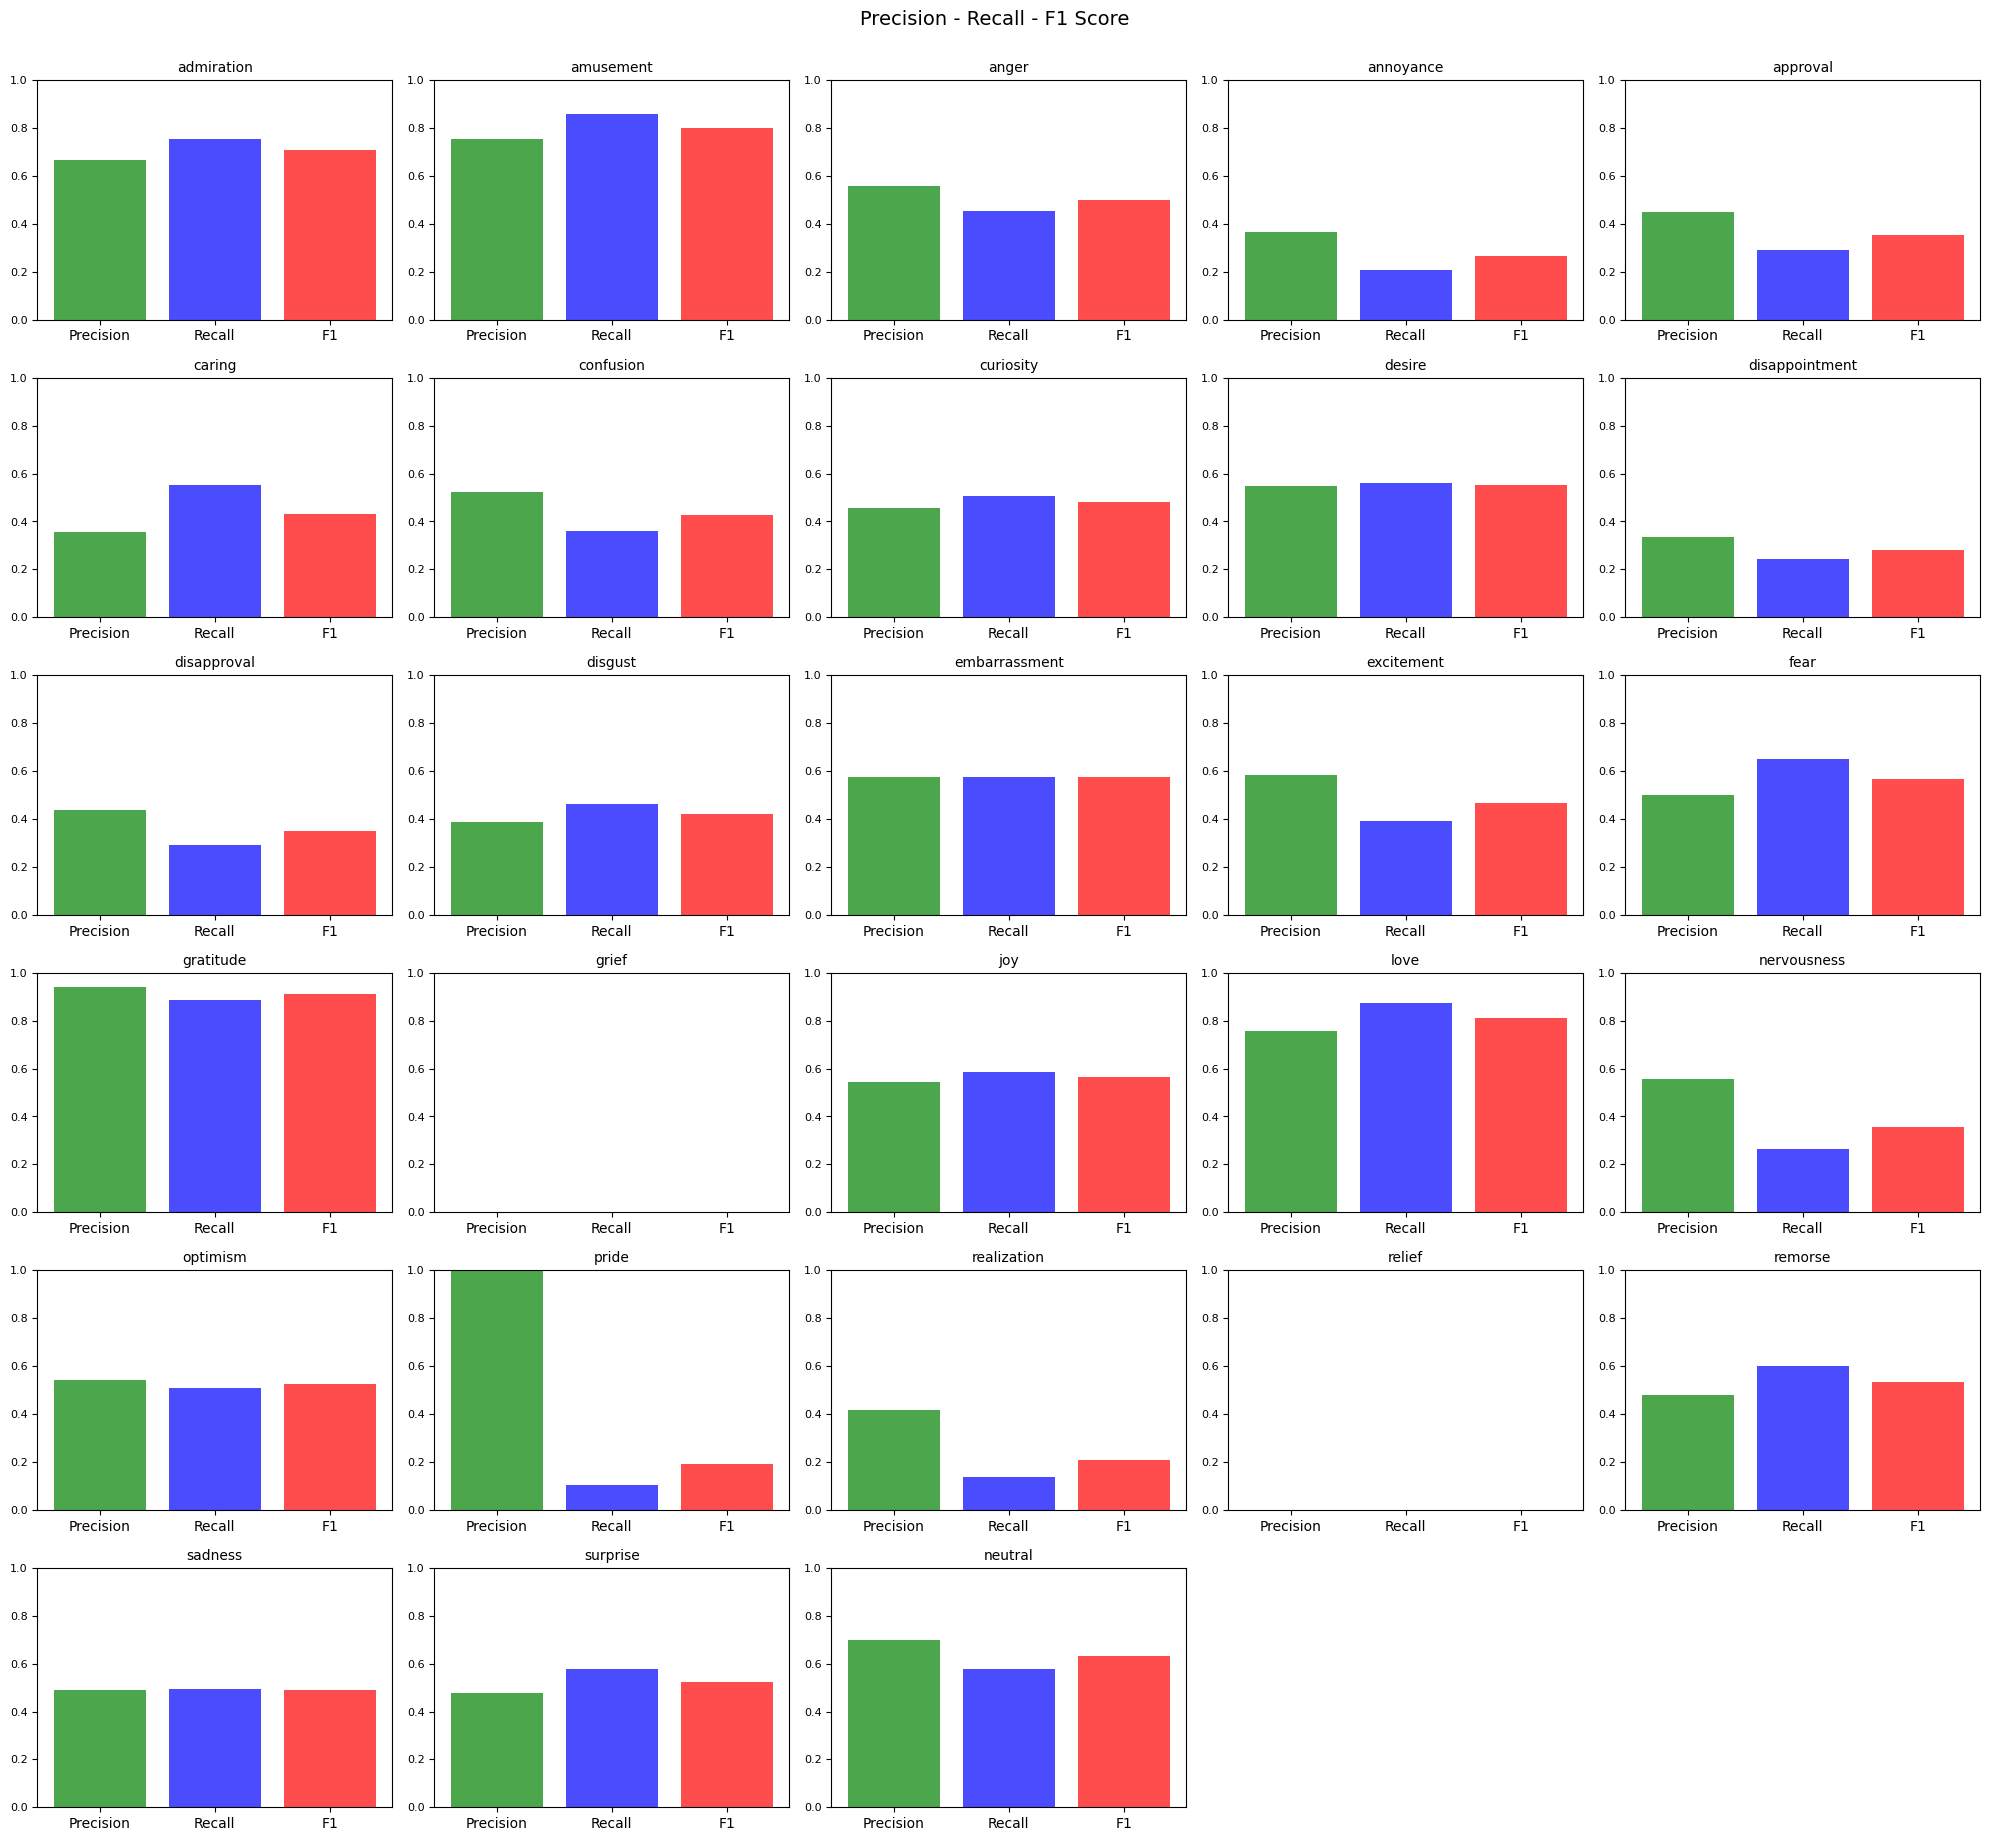

In [38]:
precisions, recalls, f1s, supports = precision_recall_fscore_support(all_labels, all_preds, average=None)

labels = [model.config.id2label[i] for i in range(len(precisions))]

df_metrics = pd.DataFrame({
    'label': labels,
    'precision': precisions,
    'recall': recalls,
    'f1': f1s,
    'support': supports
})

n_labels = len(df_metrics)
cols = 5  
rows = (n_labels + cols - 1) // cols  

fig, axs = plt.subplots(rows, cols, figsize=(cols * 4, rows * 3))
axs = axs.flatten()  

colors = ['green', 'blue', 'red']  

for i, row in enumerate(df_metrics.itertuples()):
    ax = axs[i]
    ax.bar(['Precision', 'Recall', 'F1'], [row.precision, row.recall, row.f1], color=colors, alpha=0.7)
    ax.set_ylim(0, 1)
    ax.set_title(row.label, fontsize=10)
    ax.set_xticks([0, 1, 2])
    ax.tick_params(axis='x', rotation=0)
    ax.tick_params(axis='y', labelsize=8)

for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.suptitle("Precision - Recall - F1 Score", fontsize=14, y=1.02)
plt.show()

In [39]:
df_metrics

,label,precision,recall,f1,support
0,admiration,0.668821,0.756856,0.710120,547
1,amusement,0.753247,0.859259,0.802768,270
2,anger,0.557692,0.453125,0.500000,192
3,annoyance,0.368421,0.207237,0.265263,304
4,approval,0.449580,0.290761,0.353135,368
5,caring,0.354260,0.552448,0.431694,143
6,confusion,0.521277,0.360294,0.426087,136
7,curiosity,0.457143,0.507937,0.481203,252
8,desire,0.546512,0.559524,0.552941,84
9,disappointment,0.333333,0.243421,0.281369,152


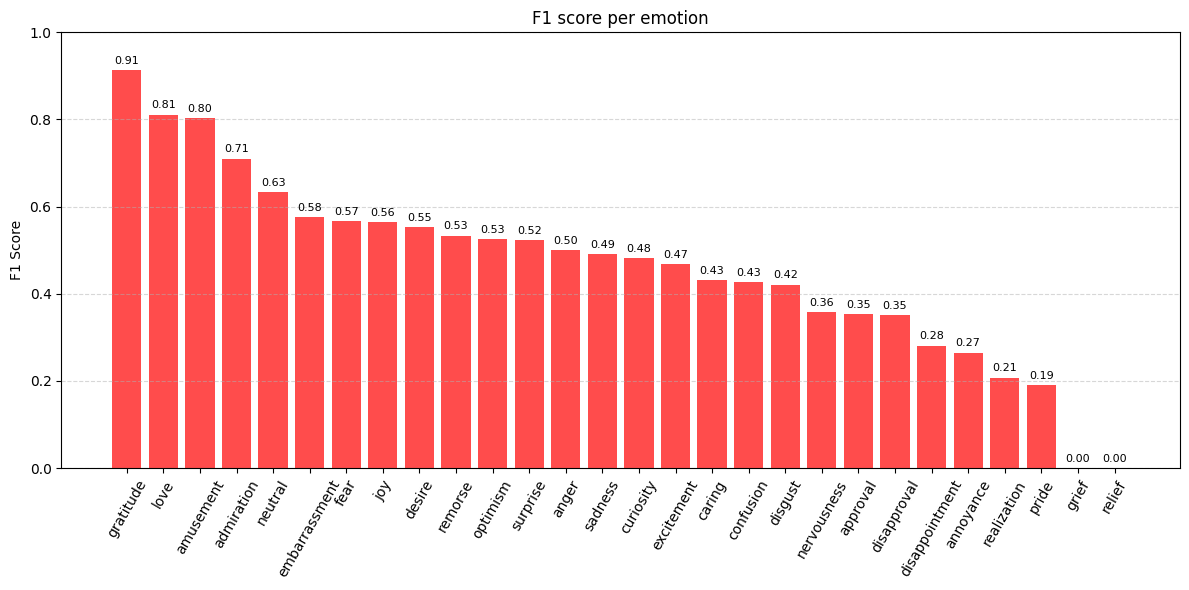

In [40]:
sorted_f1 = df_metrics.sort_values(by='f1', ascending=False)

plt.figure(figsize=(12, 6))
bars = plt.bar(sorted_f1['label'], sorted_f1['f1'], color='red', alpha=0.7)

plt.xticks(rotation=60, ha='center')
plt.ylabel("F1 Score")
plt.title("F1 score per emotion")
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.5)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01, f"{height:.2f}",
             ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()


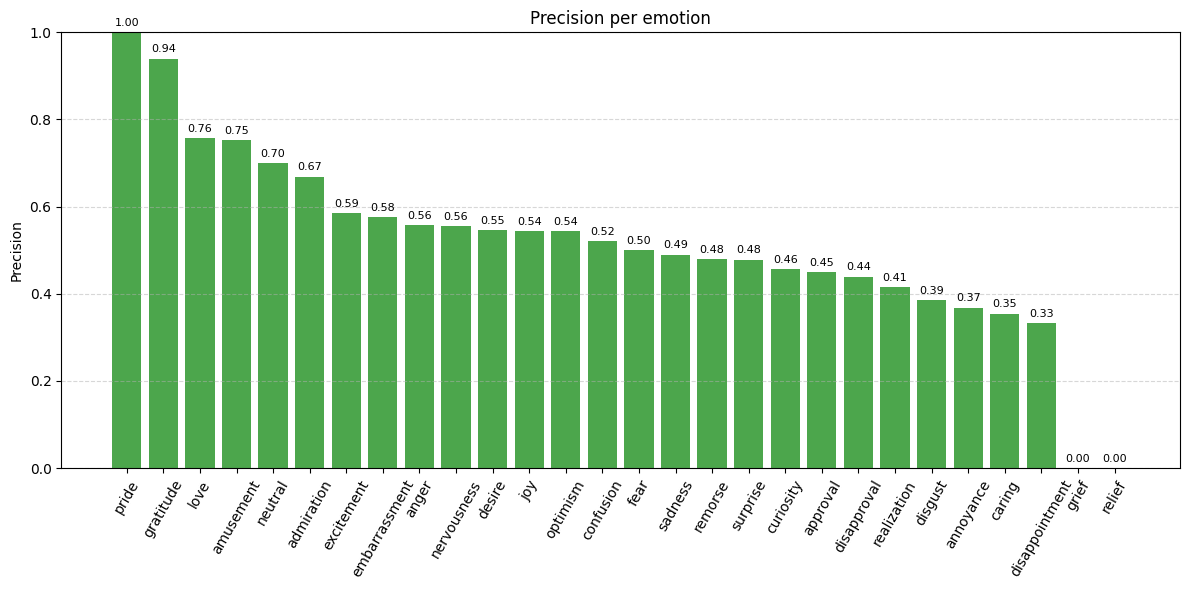

In [41]:
sorted_precision = df_metrics.sort_values(by='precision', ascending=False)

plt.figure(figsize=(12, 6))
bars = plt.bar(sorted_precision['label'], sorted_precision['precision'], color='green', alpha=0.7)

plt.xticks(rotation=60, ha='center')
plt.ylabel("Precision")
plt.title("Precision per emotion")
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.5)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01, f"{height:.2f}",
             ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

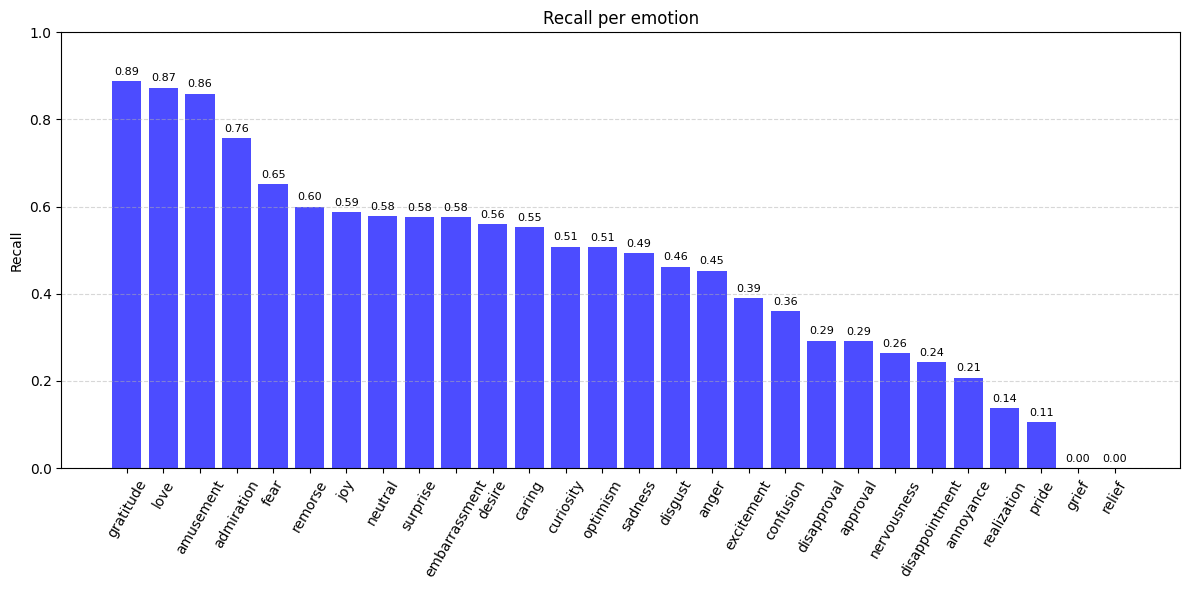

In [42]:
sorted_recall = df_metrics.sort_values(by='recall', ascending=False)

plt.figure(figsize=(12, 6))
bars = plt.bar(sorted_recall['label'], sorted_recall['recall'], color='blue', alpha=0.7)

plt.xticks(rotation=60, ha='center')
plt.ylabel("Recall")
plt.title("Recall per emotion")
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.5)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01, f"{height:.2f}",
             ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

/tmp/ipykernel_28526/1565270786.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(df['label'], rotation=60, ha='center')


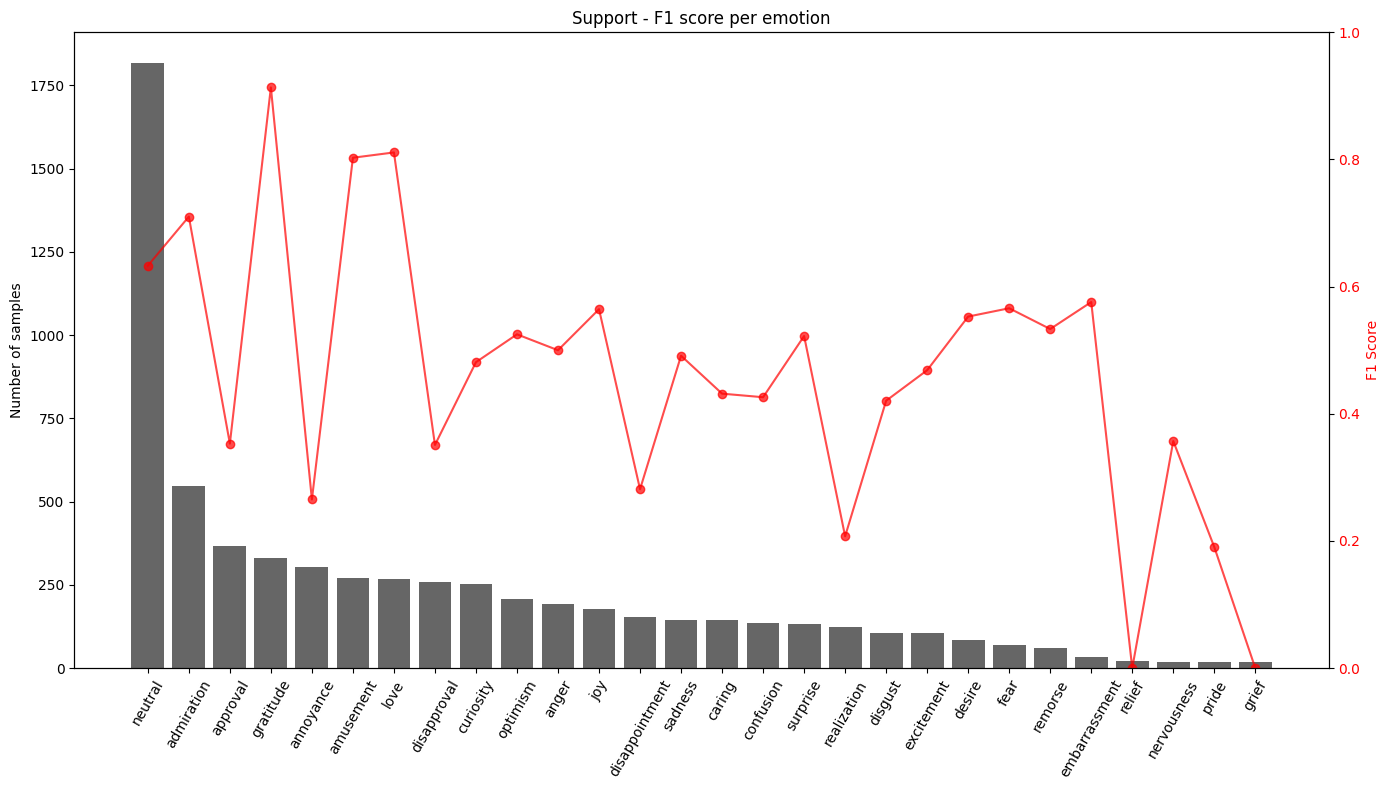

In [43]:
df = df_metrics.sort_values(by='support', ascending=False)

fig, ax1 = plt.subplots(figsize=(14, 8))

color_support = 'black'
ax1.bar(df['label'], df['support'], color=color_support, label='Support (test)', alpha=0.6)
ax1.set_ylabel('Number of samples', color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.set_xticklabels(df['label'], rotation=60, ha='center')

ax2 = ax1.twinx()
ax2.plot(df['label'], df['f1'], color='red', marker='o', label='F1 Score', alpha=0.7)
ax2.set_ylabel('F1 Score', color='red')
ax2.tick_params(axis='y', labelcolor='red')
ax2.set_ylim(0, 1)

plt.title("Support - F1 score per emotion")
fig.tight_layout()
plt.show()

/tmp/ipykernel_28526/28799819.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(df['label'], rotation=60, ha='center')


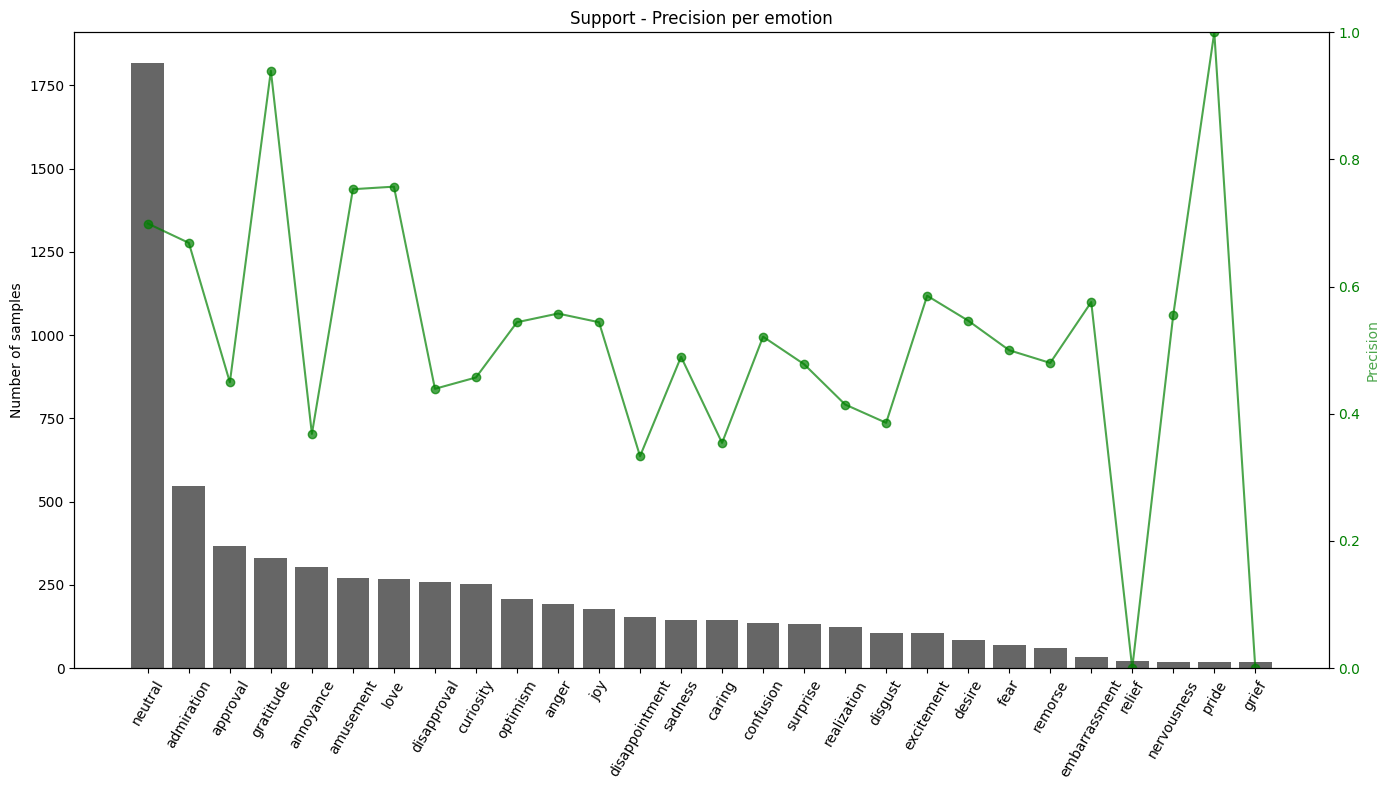

In [44]:
fig, ax1 = plt.subplots(figsize=(14, 8))

color_support = 'black'
ax1.bar(df['label'], df['support'], color=color_support, label='Support (test)', alpha=0.6)
ax1.set_ylabel('Number of samples', color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.set_xticklabels(df['label'], rotation=60, ha='center')

ax2 = ax1.twinx()
ax2.plot(df['label'], df['precision'], color='green', marker='o', label='Precision', alpha=0.7)
ax2.set_ylabel('Precision', color='green', alpha=0.7)
ax2.tick_params(axis='y', labelcolor='green')
ax2.set_ylim(0, 1)

plt.title("Support - Precision per emotion")
fig.tight_layout()
plt.show()

/tmp/ipykernel_28526/2518018146.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(df['label'], rotation=60, ha='center')


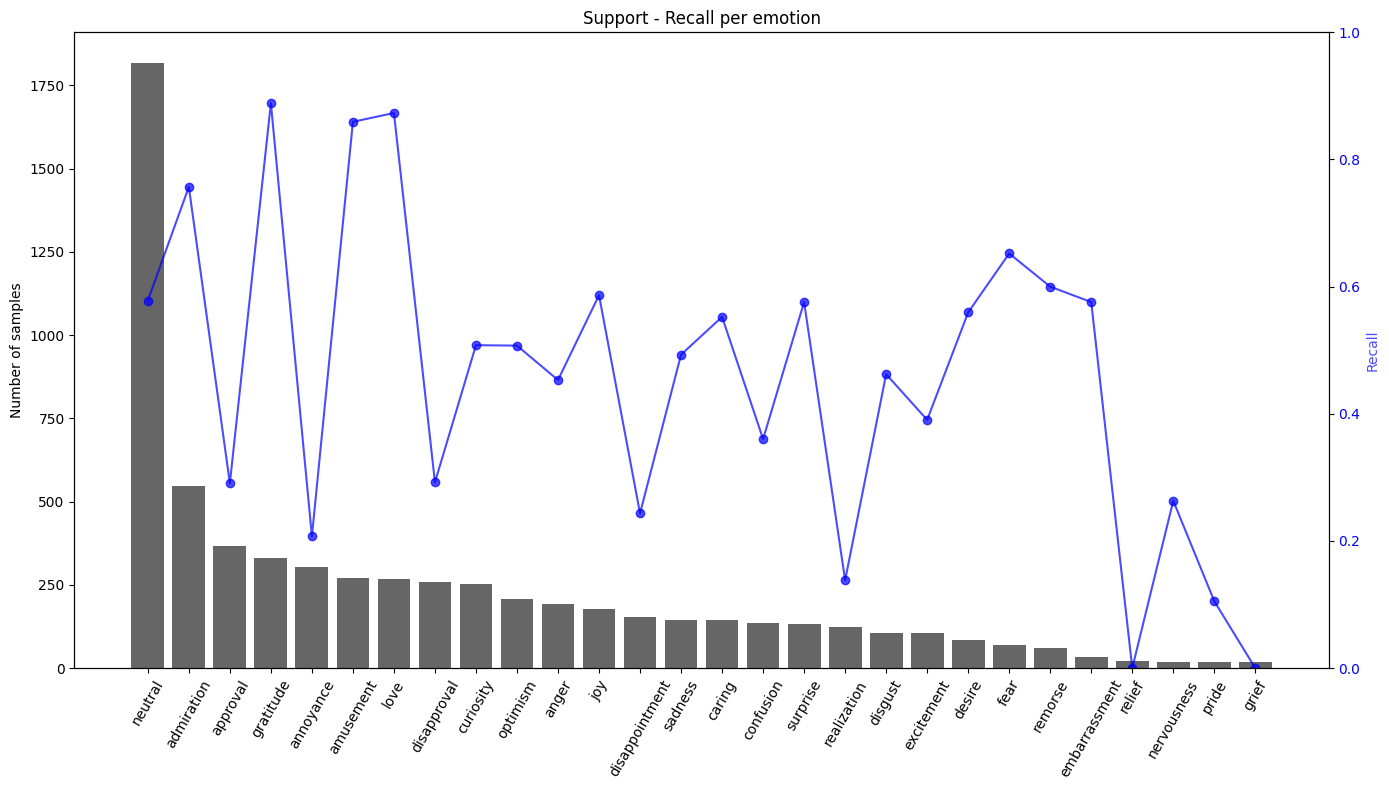

In [45]:
fig, ax1 = plt.subplots(figsize=(14, 8))

color_support = 'black'
ax1.bar(df['label'], df['support'], color=color_support, label='Support (test)', alpha=0.6)
ax1.set_ylabel('Number of samples', color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.set_xticklabels(df['label'], rotation=60, ha='center')

ax2 = ax1.twinx()
ax2.plot(df['label'], df['recall'], color='blue', marker='o', label='Recall', alpha=0.7)
ax2.set_ylabel('Recall', color='blue', alpha=0.7)
ax2.tick_params(axis='y', labelcolor='blue')
ax2.set_ylim(0, 1)

plt.title("Support - Recall per emotion")
fig.tight_layout()
plt.show()

### Samples

In [46]:
# predict_sample(text)

In [47]:
# original text
text = "I feel proud and grateful today!"
enc = tokenizer(text, return_tensors="pt", padding="max_length", max_length=128).to(device)

model.eval()
with torch.no_grad():
    outputs = model(
        **enc,
        output_hidden_states=True   
    )
    logits = outputs.logits                
    probs  = torch.sigmoid(logits)         
    hiddens = outputs.hidden_states        

print("\nLogits:", logits.cpu().numpy())
print("\nProbs:", probs.cpu().numpy().round(3))

print(f"\nTop 3 emotions:")
topk = torch.topk(probs, k=3, dim=-1)
for score, idx in zip(topk.values[0], topk.indices[0]):
    print(f"  {model.config.id2label[int(idx)]}: {float(score):.3f}")


Logits: [[-0.34110102 -6.7236896  -5.2095313  -5.461067   -4.19367    -4.317544
  -6.867579   -5.783476   -5.166884   -5.4841747  -6.099072   -5.88253
  -5.265362   -3.0673192  -6.3817563   0.5039618  -6.3739953  -2.6318867
  -5.8808846  -7.1334915  -4.3945     -1.706693   -5.1060367  -3.7029529
  -6.4387856  -6.625899   -5.3298583  -3.3417816 ]]

Probs: [[0.416 0.001 0.005 0.004 0.015 0.013 0.001 0.003 0.006 0.004 0.002 0.003
  0.005 0.044 0.002 0.623 0.002 0.067 0.003 0.001 0.012 0.154 0.006 0.024
  0.002 0.001 0.005 0.034]]

Top 3 emotions:
  gratitude: 0.623
  admiration: 0.416
  pride: 0.154


### Embeddings (before vs post fine tuning)

In [48]:
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D  
from scipy.spatial.distance import cosine

In [49]:
tokenizer = AutoTokenizer.from_pretrained("roberta-base")
model_pre  = AutoModelForSequenceClassification.from_pretrained("roberta-base").to(device)
model_fine = AutoModelForSequenceClassification.from_pretrained(save_path).to(device)

model_pre.config.output_hidden_states  = True
model_pre.eval()

model_fine.config.output_hidden_states = True
model_fine.eval()

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

In [50]:
def get_enc(idx):
    subset_encodings = {
        "input_ids": test_encodings['input_ids'][idx].to(device),
        "attention_mask": test_encodings['attention_mask'][idx].to(device)
    }
    return subset_encodings


def plot_3d(subset_encodings, sentence):
    inputs = {
            "input_ids": subset_encodings["input_ids"].unsqueeze(0),
            "attention_mask":subset_encodings["attention_mask"].unsqueeze(0),
        }

    with torch.no_grad():
        out_pre  = model_pre(**inputs,  output_hidden_states=True)
        out_fine = model_fine(**inputs, output_hidden_states=True)

    hs_pre  = out_pre.hidden_states[-1].squeeze(0)
    hs_fine = out_fine.hidden_states[-1].squeeze(0)

    # PCA 3 components
    X   = torch.cat([hs_pre, hs_fine], dim=0).cpu().numpy()
    pca = PCA(n_components=3)
    X3  = pca.fit_transform(X)
    L   = hs_pre.size(0)

    toks_str = tokenizer.convert_ids_to_tokens(inputs["input_ids"].squeeze().tolist())

    cos_sims = []
    for j, tok in enumerate(toks_str):
        v_pre  = hs_pre[j].cpu().numpy()
        v_post = hs_fine[j].cpu().numpy()
        sim = 1 - cosine(v_pre, v_post)      
        cos_sims.append((tok, sim))
    
    cos_sims.sort(key=lambda x: x[1], reverse=True)

    for tok, sim in cos_sims:
        print(f"Token {tok}  cosine similarity={sim:.4f}")

    fig = plt.figure(figsize=(7, 6))
    ax  = fig.add_subplot(projection='3d')

    ax.scatter(X3[:L,0], X3[:L,1], X3[:L,2], label="Pre-tuning",  alpha=0.7)
    ax.scatter(X3[L:,0], X3[L:,1], X3[L:,2], label="Post-tuning", alpha=0.7)
    for j, tok in enumerate(toks_str):
        ax.text(X3[j,0], X3[j,1], X3[j,2], tok, fontsize=10)
        ax.text(X3[L+j,0], X3[L+j,1], X3[L+j,2], tok, fontsize=10)

    for j in range(L):
        ax.plot(
        [X3[j,0],   X3[L+j,0]],
        [X3[j,1],   X3[L+j,1]],
        [X3[j,2],   X3[L+j,2]],
        color="gray", linewidth=0.5
        )
    ax.set_title(f"Sentence \"{sentence}\"", pad=10)
    ax.set_xlabel("PC1" ,labelpad=8)
    ax.set_ylabel("PC2", labelpad=8)
    ax.set_zlabel("PC3", labelpad=12)
    ax.legend(fontsize=8)

    plt.tight_layout()
    plt.show()

Label: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

Token Who  cosine similarity=0.1718
Token Ġthis  cosine similarity=0.1111
Token a  cosine similarity=0.1079
Token Ġreally  cosine similarity=0.1039
Token Ġcreepy  cosine similarity=0.0992
Token </s>  cosine similarity=0.0948
Token <pad>  cosine similarity=0.0880
Token <pad>  cosine similarity=0.0880
Token <pad>  cosine similarity=0.0880
Token <pad>  cosine similarity=0.0880
Token <pad>  cosine similarity=0.0880
Token <pad>  cosine similarity=0.0880
Token <pad>  cosine similarity=0.0880
Token <pad>  cosine similarity=0.0880
Token <pad>  cosine similarity=0.0880
Token <pad>  cosine similarity=0.0880
Token <pad>  cosine similarity=0.0880
Token <pad>  cosine similarity=0.0880
Token <pad>  cosine similarity=0.0880
Token <pad>  cosine similarity=0.0880
Token <pad>  cosine similarity=0.0880
Token <pad>  cosine similarity=0.0880
Token <pad>  cosine similarity=0.0880
Token <pad>  cosine similarity=0.088

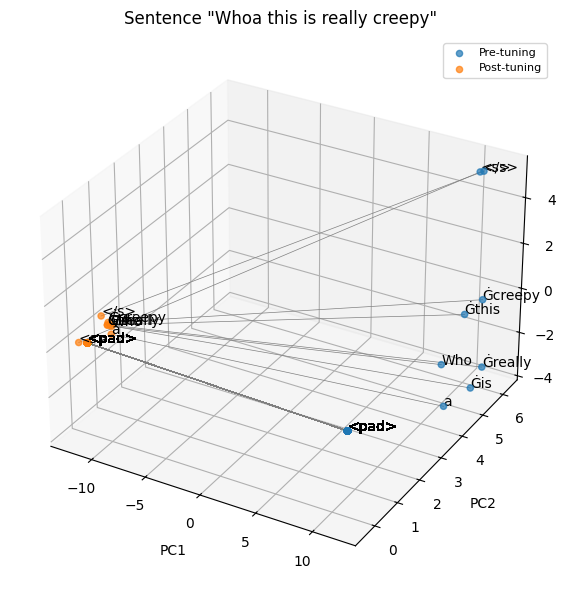

In [51]:
# index 0
idx = 0
sentence = X_test['text'].iloc[idx]
label = y_test.iloc[idx]
subset_encodings = get_enc(idx)

print(f"Label: {label}\n")
plot_3d(subset_encodings=subset_encodings, sentence=sentence)

### How specific emotions are used across topics to shape opinion?

In [52]:
def one_hot_to_emotion(one_hot):
    idxs = [i for i, v in enumerate(one_hot) if v == 1]
    list_emotions = [emotions[i] for i in idxs]
    return list_emotions

In [53]:
# element 0 -> neutral
print(dataset['labels'].iloc[0])
one_hot_to_emotion(dataset['labels'].iloc[0])

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]


['neutral']

In [54]:
preds_df = pd.DataFrame(all_preds, columns=emotions)
results = pd.concat([X_test.reset_index(drop=True), preds_df], axis=1)

topic_counts = results.groupby('topic')[emotions].sum()
topic_counts

,admiration,amusement,anger,annoyance,approval,caring,confusion,curiosity,desire,disappointment,...,love,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral
topic,,,,,,,,,,,,,,,,,,,,,
film and TV series,54,21,12,14,28,11,6,23,13,10,...,40,1,15,0,3,0,2,8,15,132
humor,155,90,46,33,54,32,30,74,15,24,...,82,2,34,0,13,0,17,48,51,379
love and relationship,122,48,20,20,44,95,13,29,11,16,...,56,3,51,1,6,0,20,41,30,179
other,84,21,19,26,25,25,12,34,10,15,...,30,0,16,0,3,0,6,11,13,167
politics,79,57,27,33,48,46,22,67,11,18,...,32,0,25,1,8,0,15,14,25,374
sport,90,45,25,26,26,10,8,32,20,19,...,47,3,39,0,6,0,9,13,15,195
videogames,35,26,7,19,13,4,3,21,6,9,...,22,0,13,0,2,0,6,10,10,77


In [55]:
# split emotions: positive, negative, ambiguous, neutral
positive   = {"amusement","excitement","joy","love","desire","optimism",
              "caring","pride","admiration","gratitude","relief","approval","realization"}
negative   = {"fear","nervousness","remorse","embarrassment","disappointment",
              "sadness","grief","disgust","anger","annoyance","disapproval"}
ambiguous  = {"surprise","curiosity","confusion"}
neutral    = {"neutral"}

color_map = {}
for lbl in emotions:
    if lbl in positive:  color_map[lbl] = 'green'
    elif lbl in negative: color_map[lbl] = 'red'
    elif lbl in ambiguous:color_map[lbl] = 'gray'
    else:                 color_map[lbl] = 'black'  

color_map

{'admiration': 'green',
 'amusement': 'green',
 'anger': 'red',
 'annoyance': 'red',
 'approval': 'green',
 'caring': 'green',
 'confusion': 'gray',
 'curiosity': 'gray',
 'desire': 'green',
 'disappointment': 'red',
 'disapproval': 'red',
 'disgust': 'red',
 'embarrassment': 'red',
 'excitement': 'green',
 'fear': 'red',
 'gratitude': 'green',
 'grief': 'red',
 'joy': 'green',
 'love': 'green',
 'nervousness': 'red',
 'optimism': 'green',
 'pride': 'green',
 'realization': 'green',
 'relief': 'green',
 'remorse': 'red',
 'sadness': 'red',
 'surprise': 'gray',
 'neutral': 'black'}

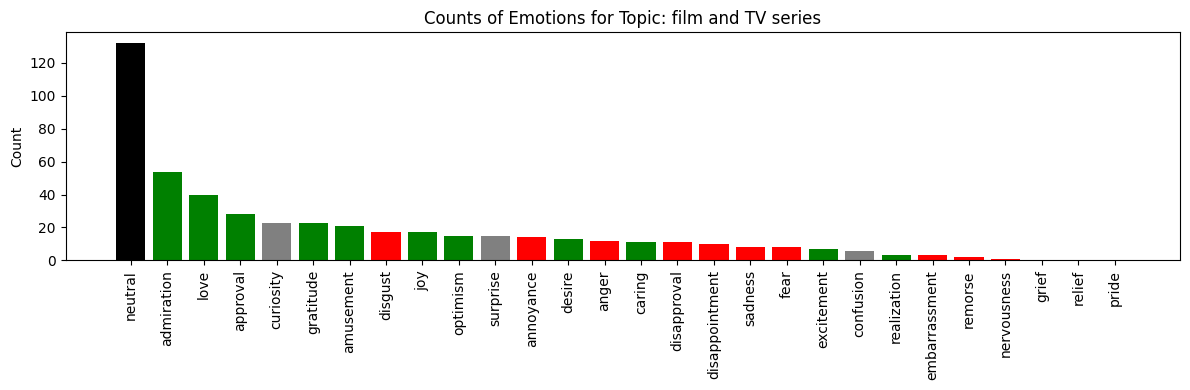

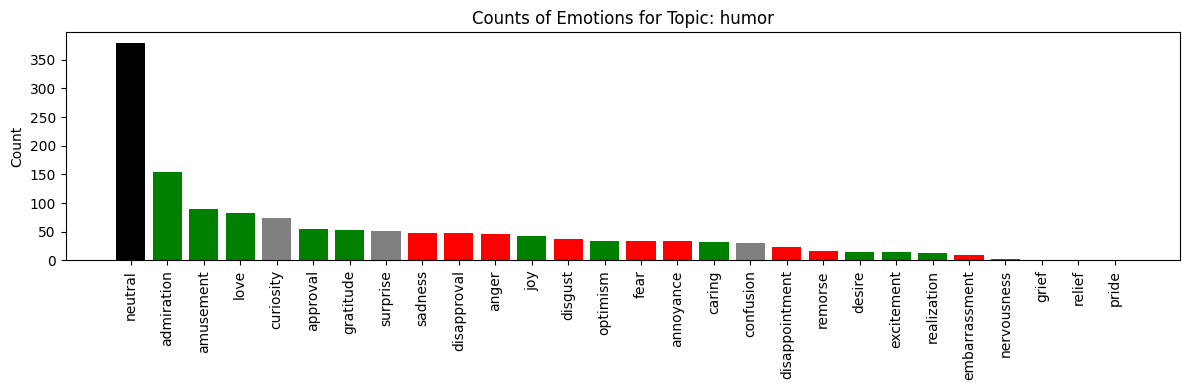

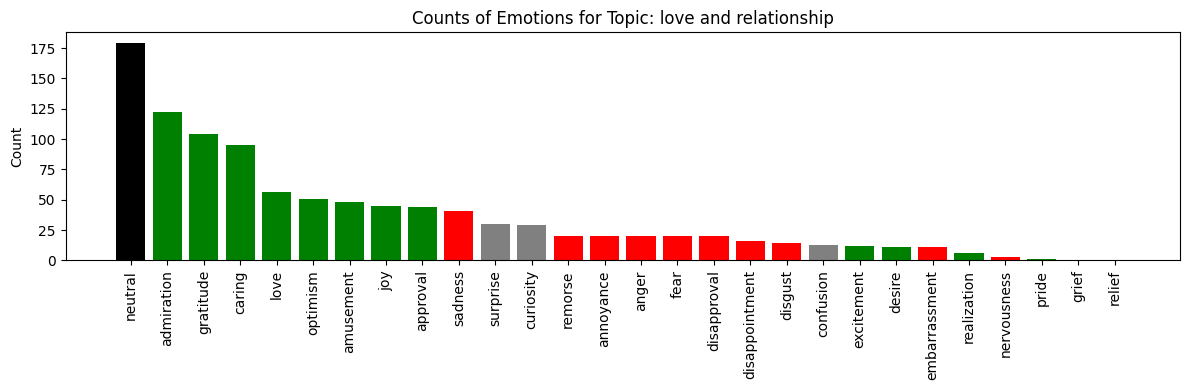

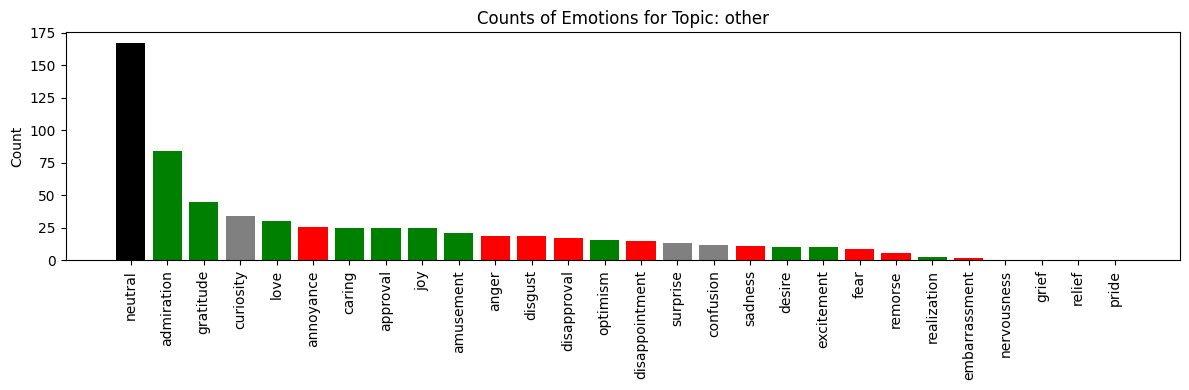

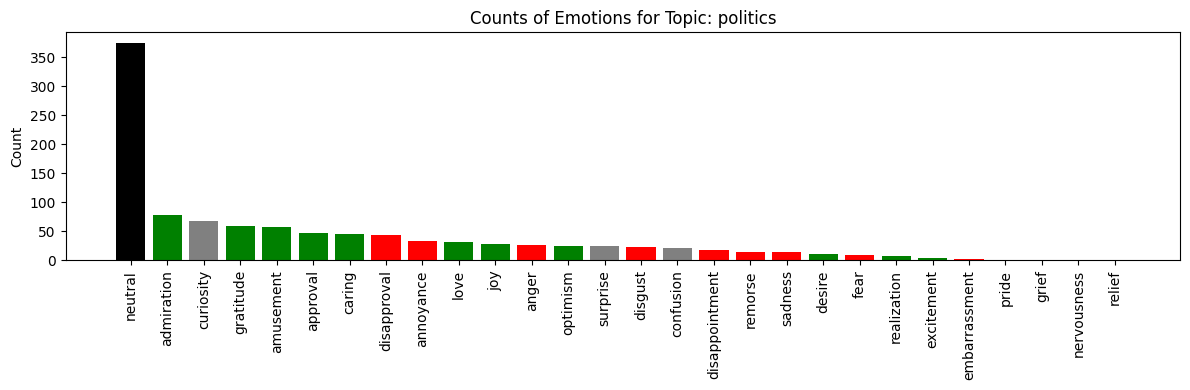

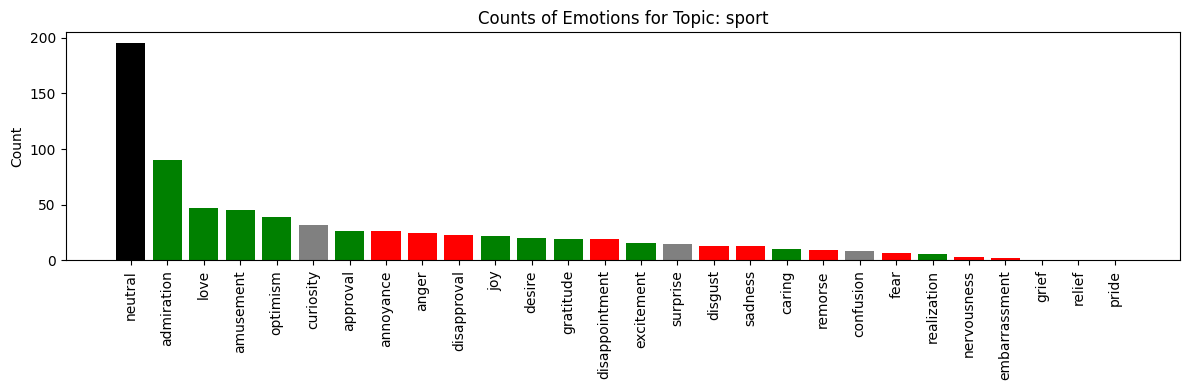

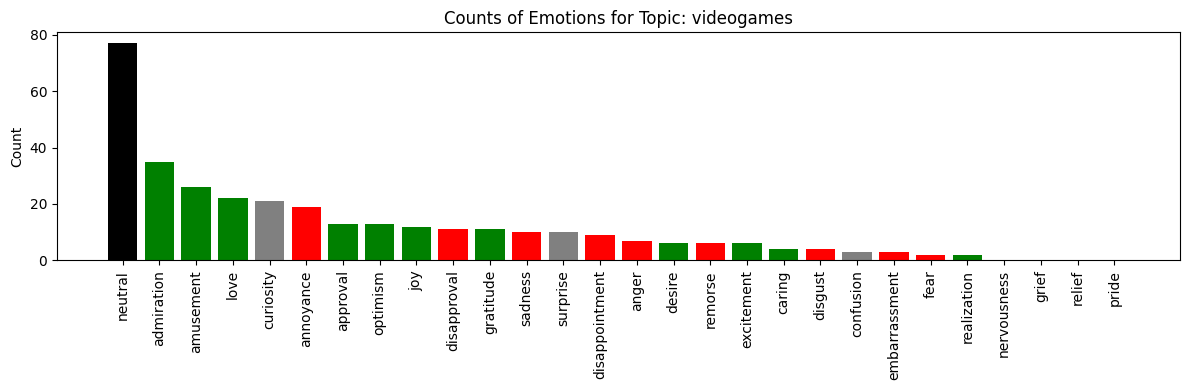

In [56]:
for topic in topic_counts.index:
    counts = topic_counts.loc[topic].sort_values(ascending=False)
    
    labels = counts.index.tolist()
    values = counts.values
    positions = range(len(labels))

    plt.figure(figsize=(12, 4))

    plt.bar(
        positions,
        values,
        color=[color_map[lbl] for lbl in labels]
    )

    plt.xticks(positions, labels, rotation=90)
    plt.ylabel('Count')
    plt.title(f'Counts of Emotions for Topic: {topic}')

    plt.tight_layout()
    plt.show()

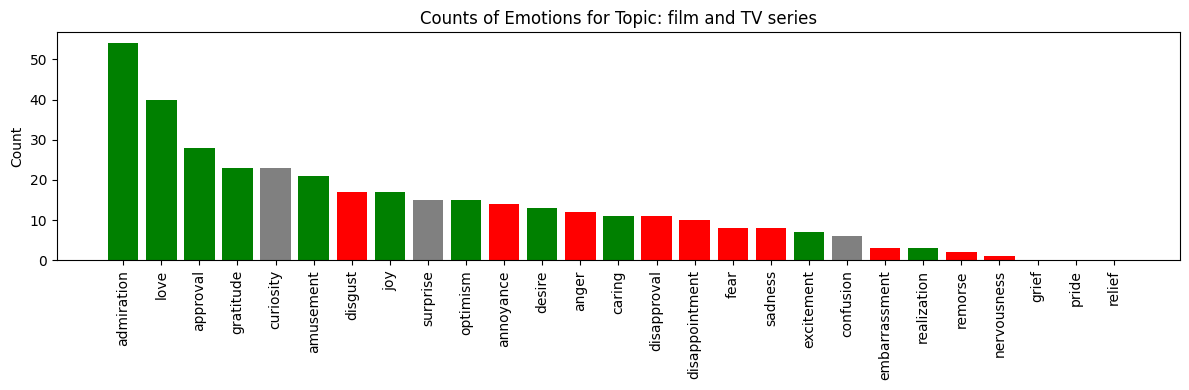

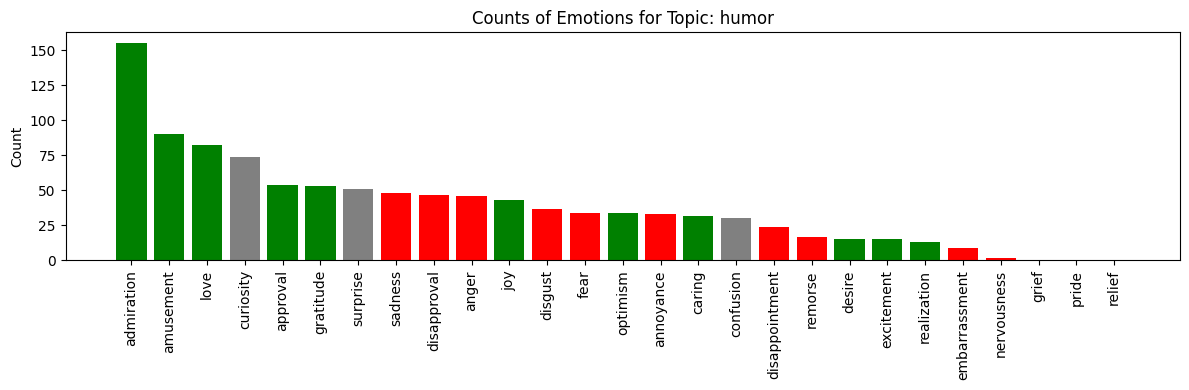

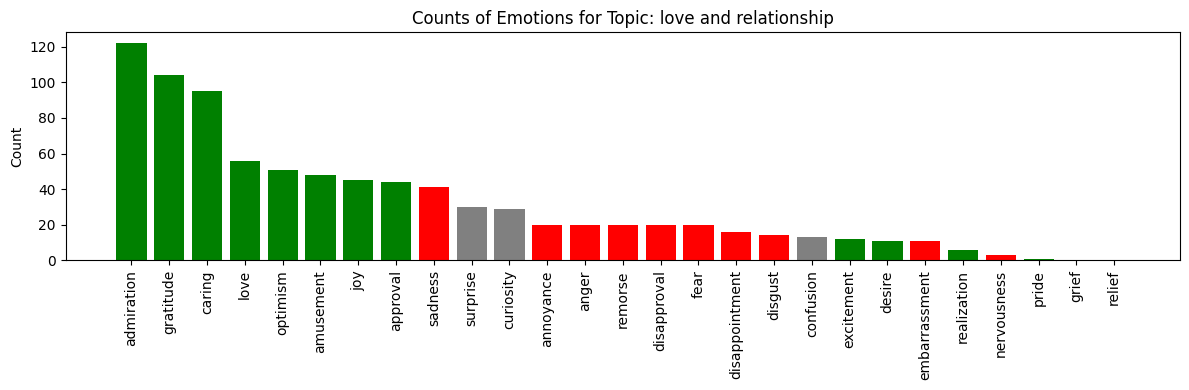

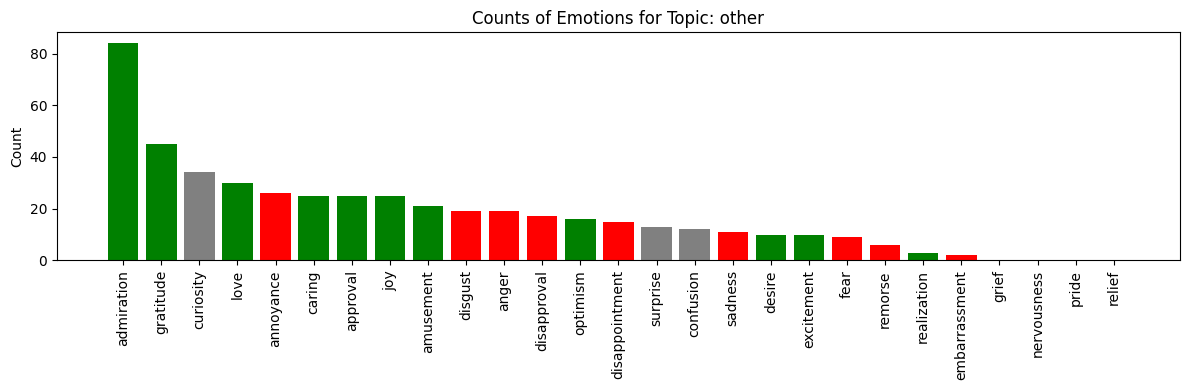

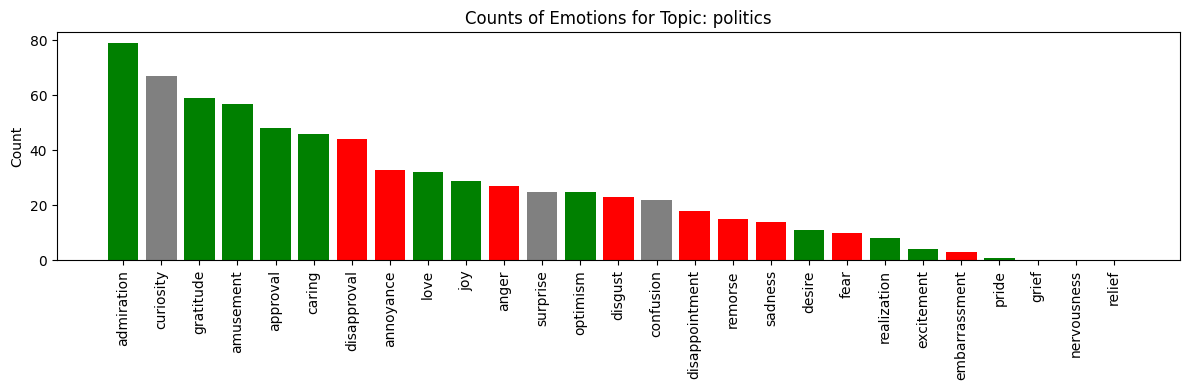

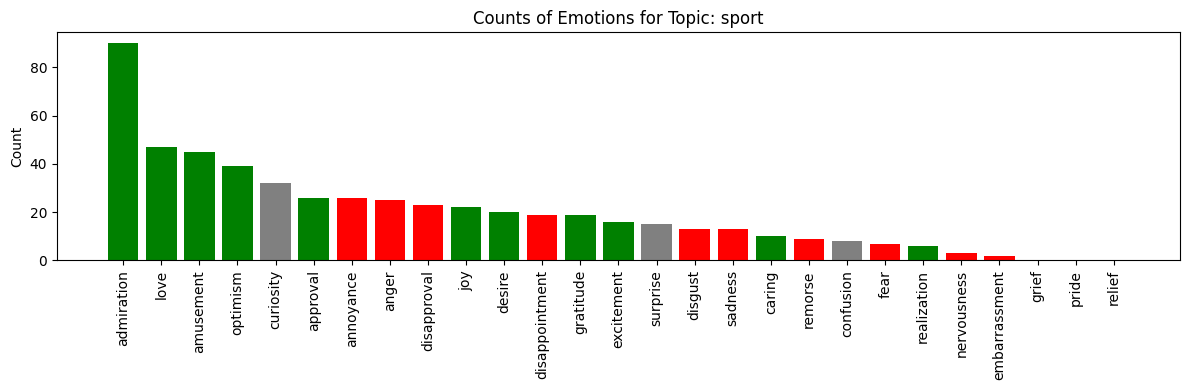

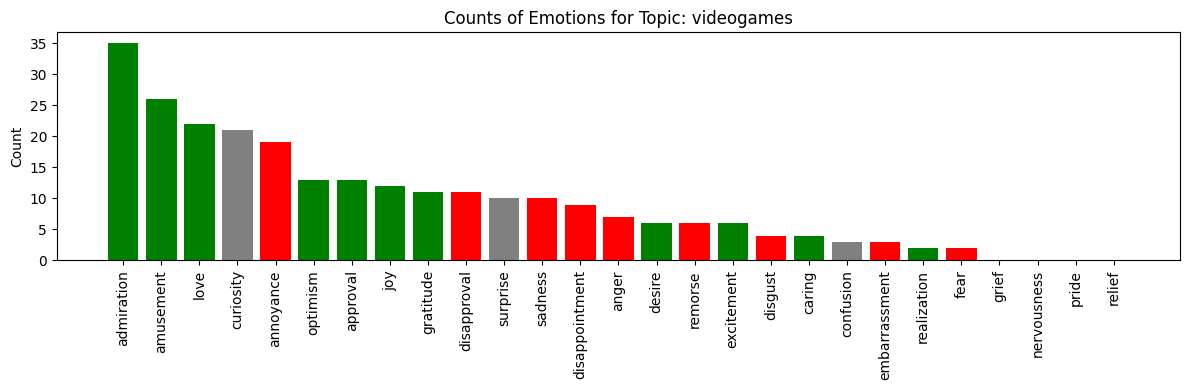

In [57]:
for topic in topic_counts.index:
    # remove label "neutral"
    counts = topic_counts.loc[topic].drop(labels=['neutral'])
    counts = counts.sort_values(ascending=False)
    
    labels   = counts.index.tolist()
    values   = counts.values
    positions = range(len(labels))

    plt.figure(figsize=(12, 4))
    plt.bar(
        positions,
        values,
        color=[color_map[lbl] for lbl in labels]
    )
    plt.xticks(positions, labels, rotation=90)
    plt.ylabel('Count')
    plt.title(f'Counts of Emotions for Topic: {topic}')
    plt.tight_layout()
    plt.show()

In [58]:
results

,text,id,author,subreddit,created_utc,cluster,topic,admiration,amusement,anger,...,love,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral
0,Whoa this is really creepy,ee05ddd,Di-Vanci,morbidquestions,2019-01-13,0,humor,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"Ok, I will take this with a pinch of salt, but...",ef43ust,EloCross,relationships,2019-01-27,4,love and relationship,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"I love bloodborne, I started my second play th...",ediu7qx,THE-EMPEROR069,dating,2019-01-08,4,love and relationship,0,0,0,...,1,0,0,0,0,0,0,0,0,0
3,"Oh my goodness, I'm so glad you were there too...",ede1w2h,shadedferns,TalesFromRetail,2019-01-06,1,other,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Yeah -- a woman who expects a guy to never eve...,efgxbk9,reluctantly_red,PurplePillDebate,2019-01-31,3,politics,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5422,De nada!,eelqsur,PuddleOfJelm,NoFap,2019-01-21,4,love and relationship,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5423,"Great job, now let's get two points.",ee94idc,Sabres8127,sabres,2019-01-17,2,sport,1,0,0,...,0,0,0,0,0,0,0,0,0,0
5424,RemindMe!,efe1coq,marymess,relationship_advice,2019-01-30,4,love and relationship,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5425,i love all harper news because i love the shit...,ed3uc1g,robindodge,Dodgers,2019-01-02,2,sport,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [59]:
def get_predicted_labels(row):
    return [label for label, val in row.items() if val == 1]

results['predicted_labels'] = results[emotions].apply(get_predicted_labels, axis=1)

In [60]:
results

,text,id,author,subreddit,created_utc,cluster,topic,admiration,amusement,anger,...,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral,predicted_labels
0,Whoa this is really creepy,ee05ddd,Di-Vanci,morbidquestions,2019-01-13,0,humor,0,0,0,...,0,0,0,0,0,0,0,0,0,[fear]
1,"Ok, I will take this with a pinch of salt, but...",ef43ust,EloCross,relationships,2019-01-27,4,love and relationship,0,0,0,...,0,0,0,0,0,0,0,0,0,[gratitude]
2,"I love bloodborne, I started my second play th...",ediu7qx,THE-EMPEROR069,dating,2019-01-08,4,love and relationship,0,0,0,...,0,0,0,0,0,0,0,0,0,[love]
3,"Oh my goodness, I'm so glad you were there too...",ede1w2h,shadedferns,TalesFromRetail,2019-01-06,1,other,0,0,0,...,0,0,0,0,0,0,0,0,0,[joy]
4,Yeah -- a woman who expects a guy to never eve...,efgxbk9,reluctantly_red,PurplePillDebate,2019-01-31,3,politics,0,0,0,...,0,0,0,0,0,0,0,0,1,[neutral]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5422,De nada!,eelqsur,PuddleOfJelm,NoFap,2019-01-21,4,love and relationship,0,0,0,...,0,0,0,0,0,0,0,0,1,[neutral]
5423,"Great job, now let's get two points.",ee94idc,Sabres8127,sabres,2019-01-17,2,sport,1,0,0,...,0,0,0,0,0,0,0,0,0,[admiration]
5424,RemindMe!,efe1coq,marymess,relationship_advice,2019-01-30,4,love and relationship,0,0,0,...,0,0,0,0,0,0,0,0,1,[neutral]
5425,i love all harper news because i love the shit...,ed3uc1g,robindodge,Dodgers,2019-01-02,2,sport,0,0,0,...,0,0,0,0,0,0,0,0,0,[love]


### Plots or dashboards comparing emotional tone across actors, media types, or ideological groups

In [61]:
import plotly.express as px
import plotly.graph_objects as go

In [62]:
dataset['topic'].value_counts()

topic
humor                    13791
politics                 10273
love and relationship     9026
sport                     7042
other                     5839
film and TV series        4987
videogames                3305
Name: count, dtype: int64

In [63]:
# topics
humor = results[results['topic']=='humor']
politics = results[results['topic']=='politics']
love = results[results['topic']=='love and relationship']
sport = results[results['topic']=='sport']
other = results[results['topic']=='other'] 
film = results[results['topic']=='film and TV series']
videogames = results[results['topic']=='videogames']

In [64]:
results.columns

Index(['text', 'id', 'author', 'subreddit', 'created_utc', 'cluster', 'topic',
       'admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring',
       'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval',
       'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief',
       'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization',
       'relief', 'remorse', 'sadness', 'surprise', 'neutral',
       'predicted_labels'],
      dtype='object')

In [65]:
def compare_emotions(em):

    total_texts = len(results)
    counts = results[em].sum()
    percentages = counts / total_texts * 100
    print("Percentage of texts labeled with each emotion:")
    print(percentages)

    grouped = (
        results
        .groupby('topic')[em]
        .mean()                 
        * 100
    )
    print("\n% per topic:")
    print(grouped)


    grouped.plot(kind='bar', figsize=(10,8))
    plt.ylabel('Percentage of texts (%)')
    plt.legend(labels=em)
    plt.tight_layout()
    plt.show()

Percentage of texts labeled with each emotion:
amusement    5.675327
anger        2.874516
dtype: float64

% per topic:
                       amusement     anger
topic                                     
film and TV series      4.477612  2.558635
humor                   6.607930  3.377386
love and relationship   5.015674  2.089864
other                   3.448276  3.119869
politics                5.512573  2.611219
sport                   6.578947  3.654971
videogames              8.333333  2.243590


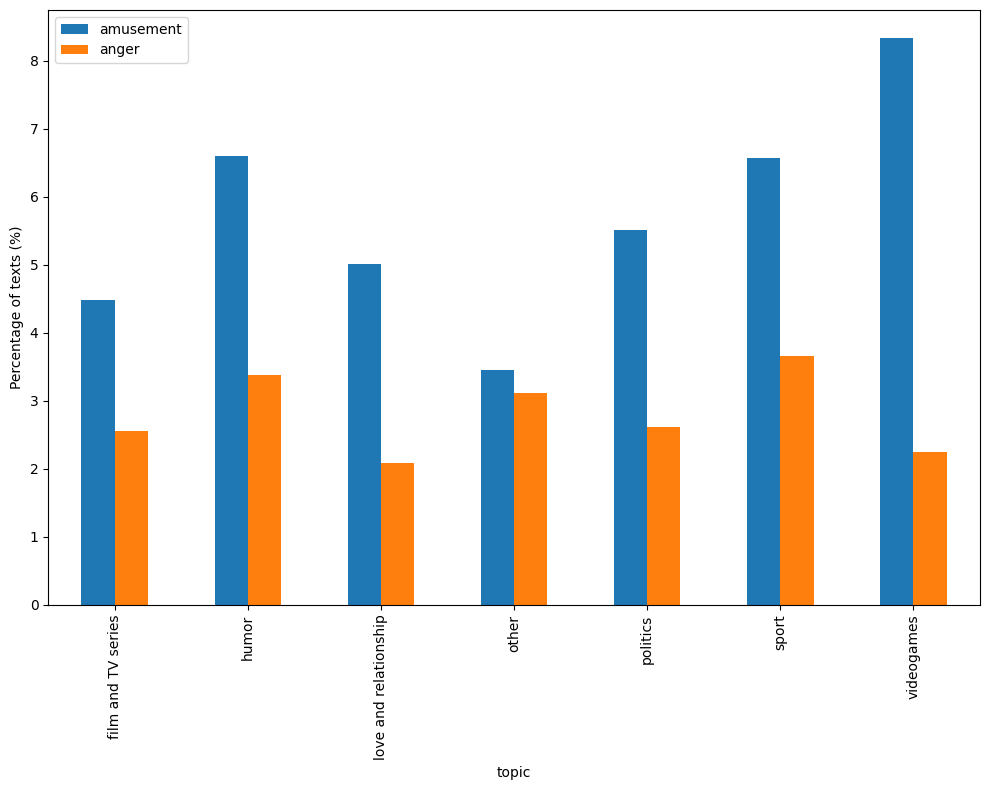

In [66]:
em = ['amusement', 'anger']

compare_emotions(em)

Percentage of texts labeled with each emotion:
surprise     2.929795
curiosity    5.159388
confusion    1.732080
dtype: float64

% per topic:
                       surprise  curiosity  confusion
topic                                                
film and TV series     3.198294   4.904051   1.279318
humor                  3.744493   5.433186   2.202643
love and relationship  3.134796   3.030303   1.358412
other                  2.134647   5.582923   1.970443
politics               2.417795   6.479691   2.127660
sport                  2.192982   4.678363   1.169591
videogames             3.205128   6.730769   0.961538


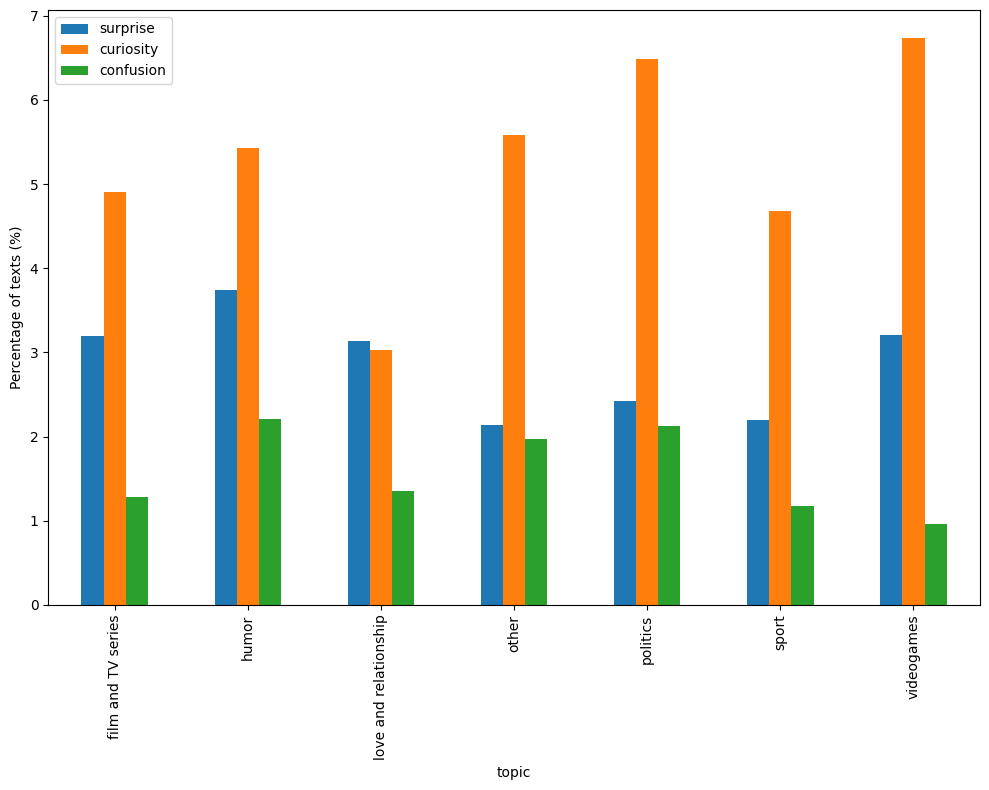

In [67]:
em = ["surprise","curiosity","confusion"]

compare_emotions(em)

Percentage of texts labeled with each emotion:
amusement    5.675327
annoyance    3.150912
dtype: float64

% per topic:
                       amusement  annoyance
topic                                      
film and TV series      4.477612   2.985075
humor                   6.607930   2.422907
love and relationship   5.015674   2.089864
other                   3.448276   4.269294
politics                5.512573   3.191489
sport                   6.578947   3.801170
videogames              8.333333   6.089744


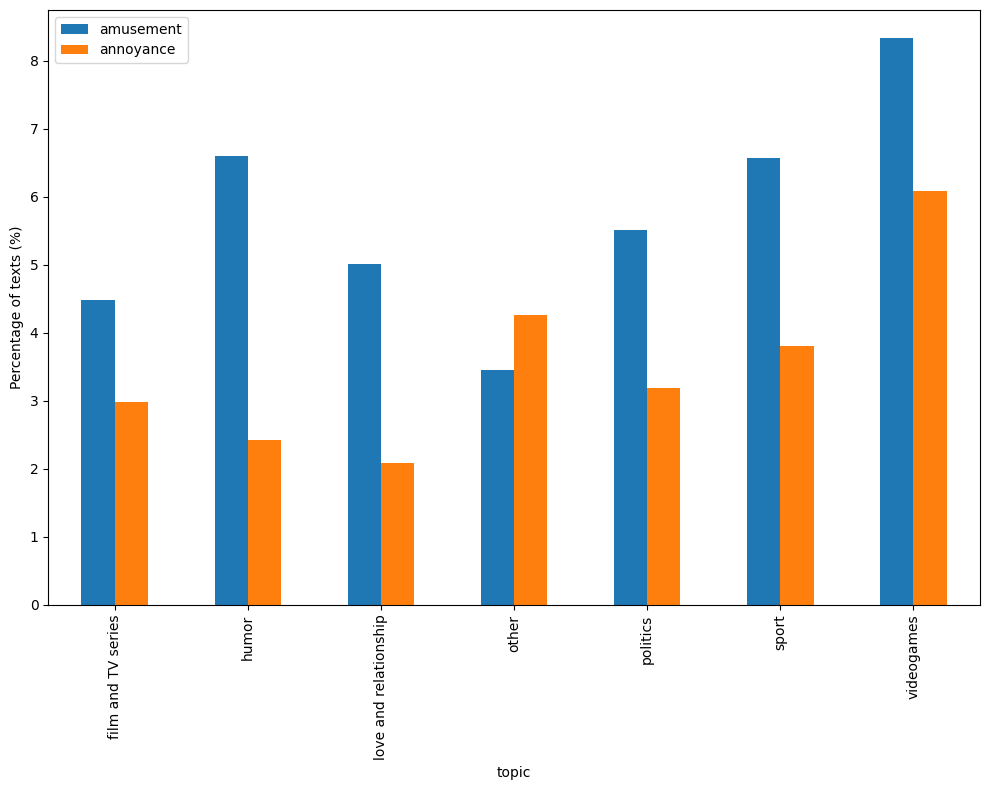

In [68]:
em = ["amusement", "annoyance"]

compare_emotions(em)

Percentage of texts labeled with each emotion:
optimism          3.556293
disappointment    2.045329
dtype: float64

% per topic:
                       optimism  disappointment
topic                                          
film and TV series     3.198294        2.132196
humor                  2.496329        1.762115
love and relationship  5.329154        1.671891
other                  2.627258        2.463054
politics               2.417795        1.740812
sport                  5.701754        2.777778
videogames             4.166667        2.884615


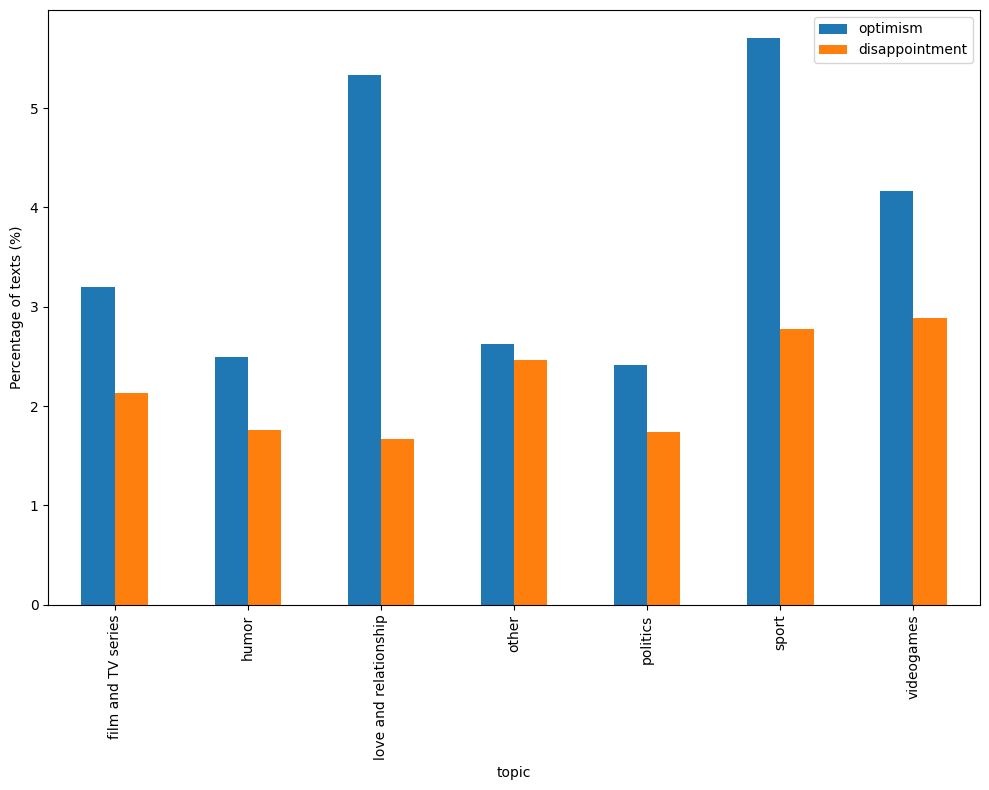

In [69]:
em = ["optimism", "disappointment"]

compare_emotions(em)

### Heatmap

In [75]:
import seaborn as sns

In [81]:
def plot_heatmap(d, topic):
    emotion_matrix = d.groupby('subreddit')[emotions].sum()
    emotion_matrix_norm = emotion_matrix.div(emotion_matrix.sum(axis=1), axis=0)

    # heatmap
    plt.figure(figsize=(12, 20))  
    sns.heatmap(emotion_matrix_norm, 
                cmap='YlGnBu',
                linewidths=0.4)

    plt.title(f"Distribution of emotions per subreddit (topic: {topic})")
    plt.xlabel("Emotions")
    plt.ylabel("Subreddit")
    plt.tight_layout()
    plt.show()

#### Politics

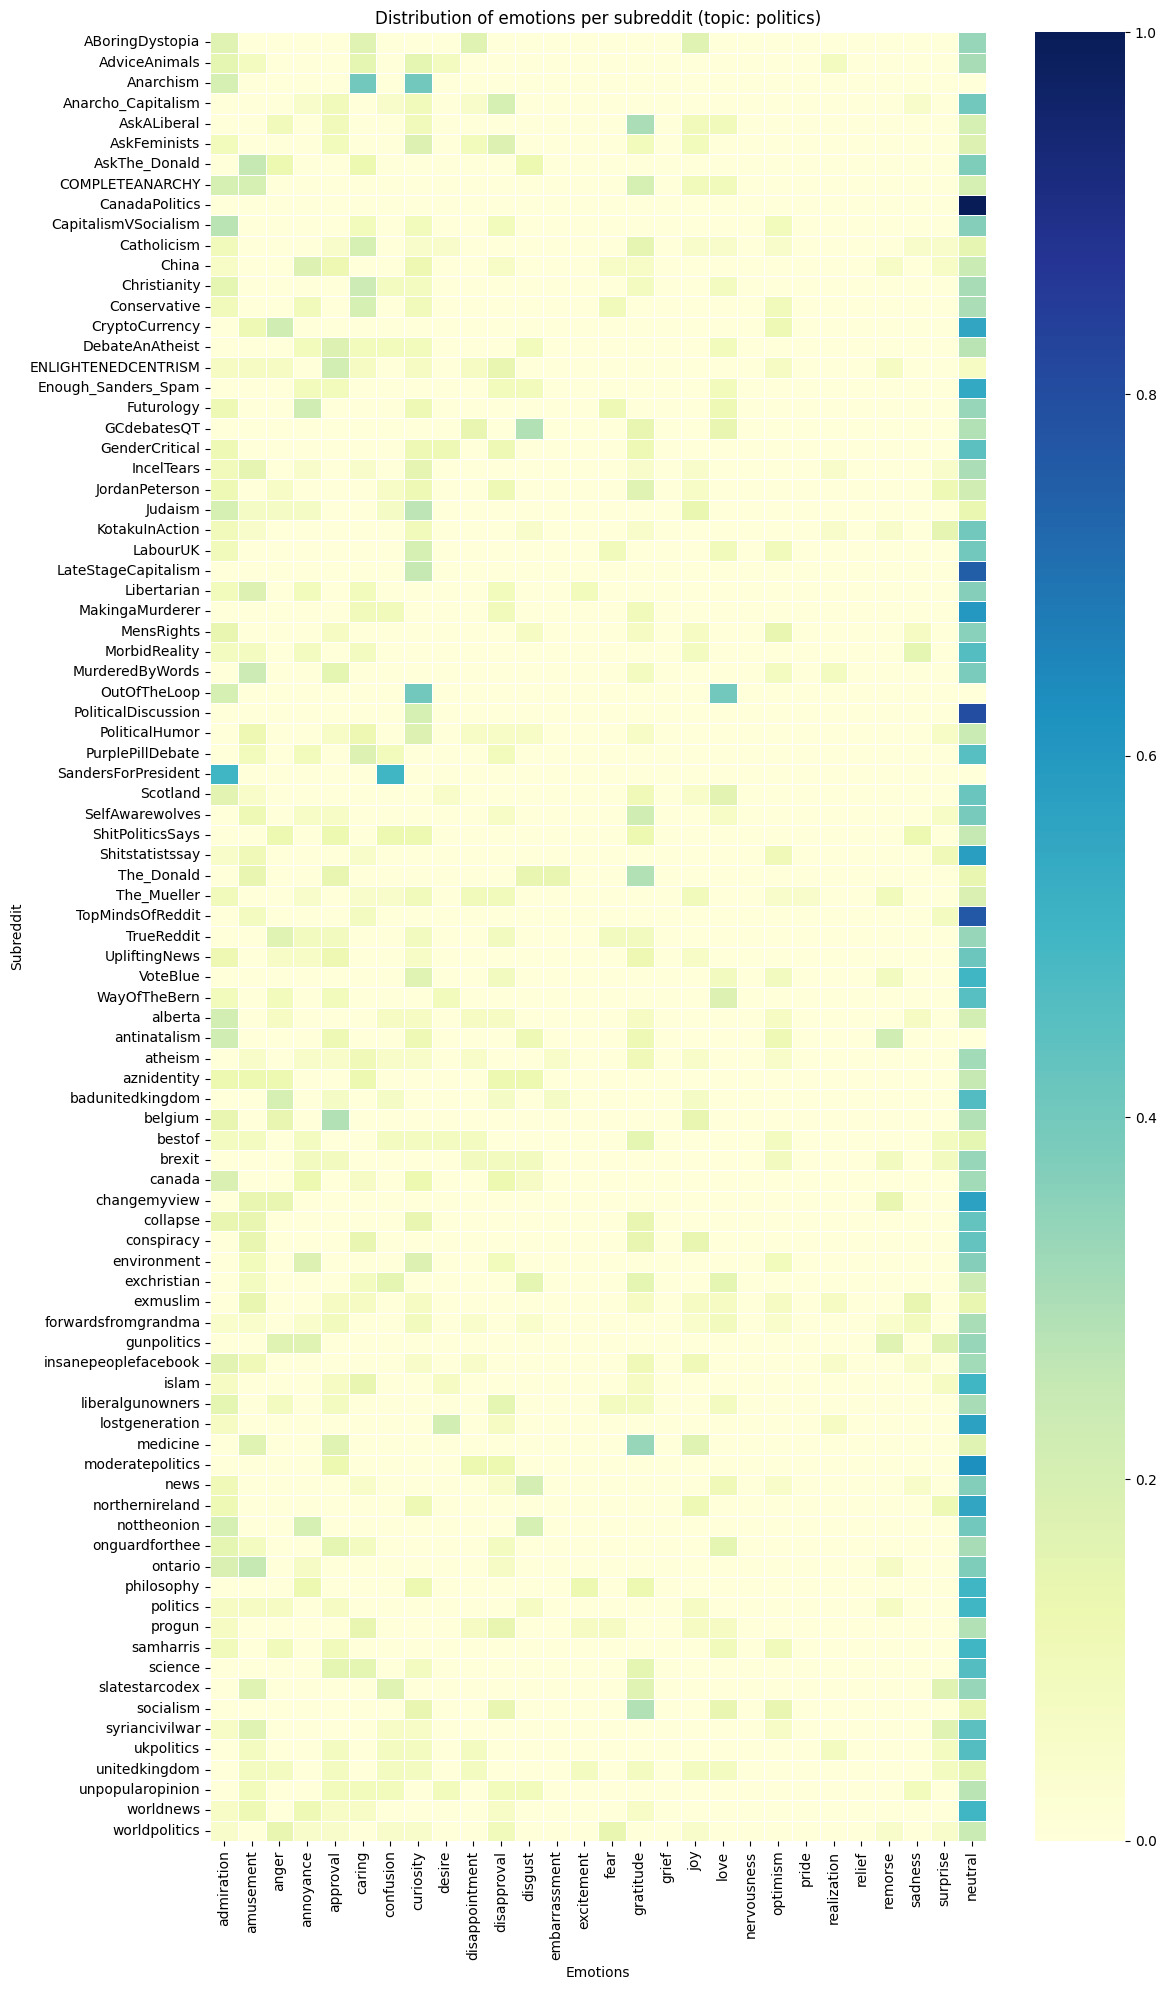

In [82]:
plot_heatmap(politics, "politics")

#### Videogames

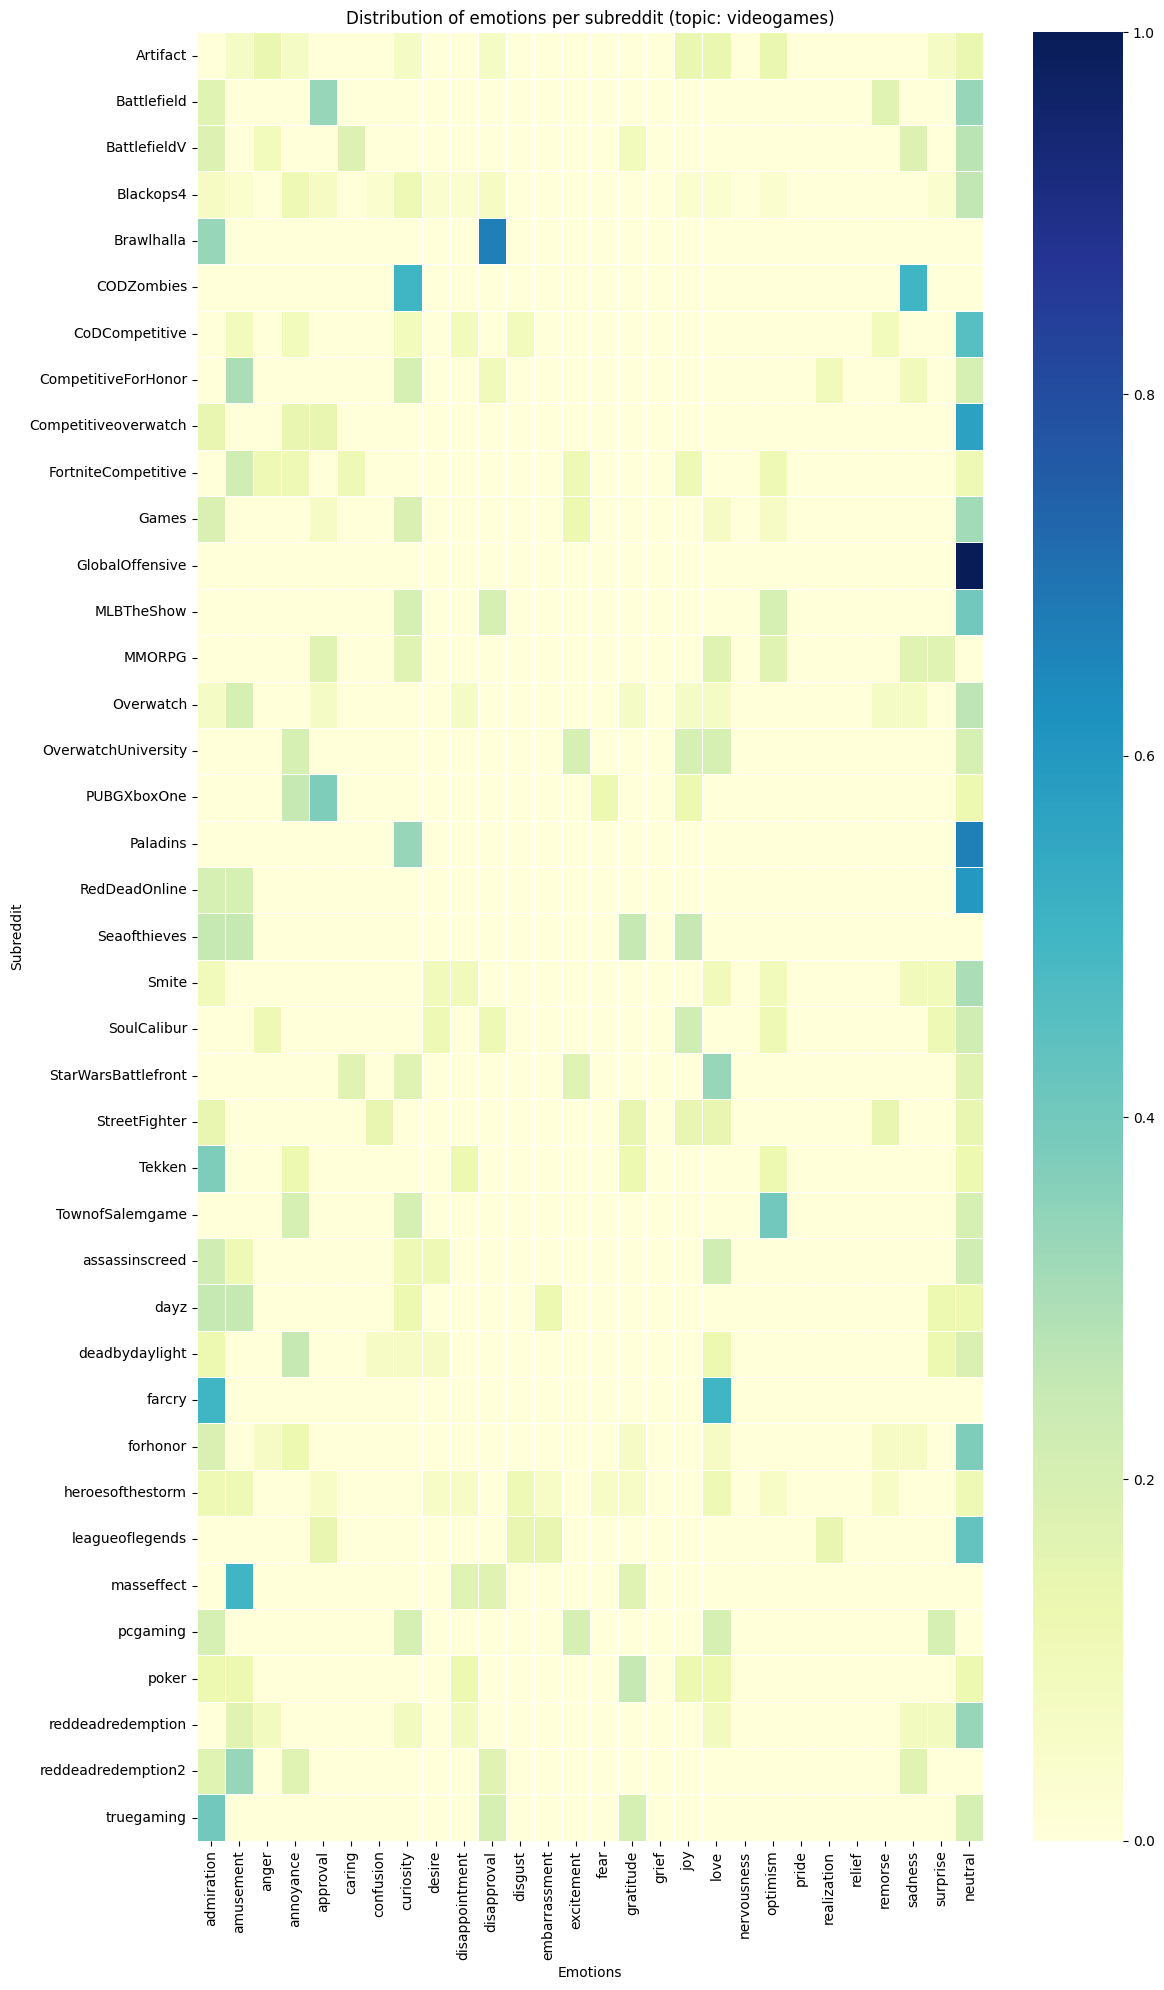

In [83]:
plot_heatmap(videogames, "videogames")

#### Films

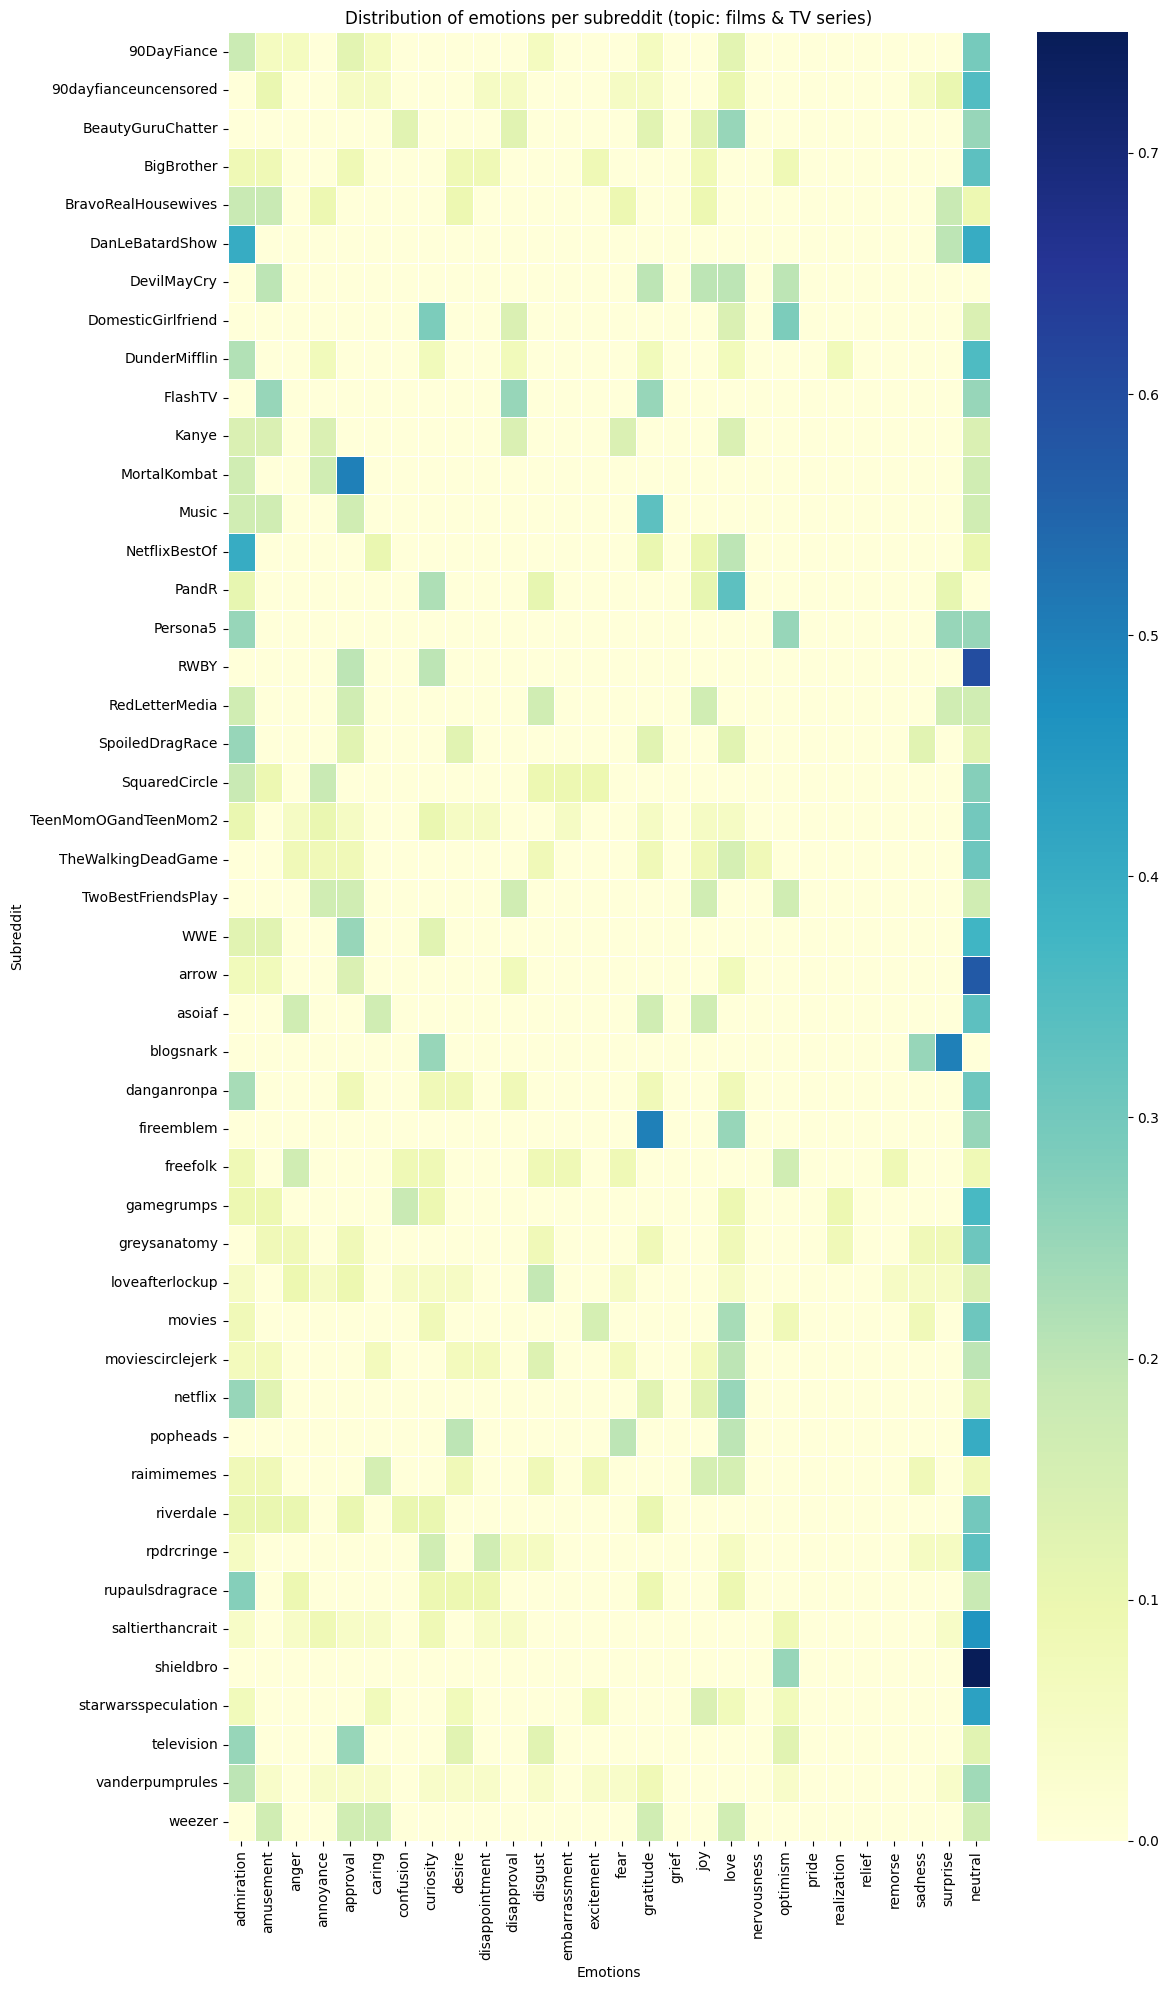

In [84]:
plot_heatmap(film, "films & TV series")

#### Sport

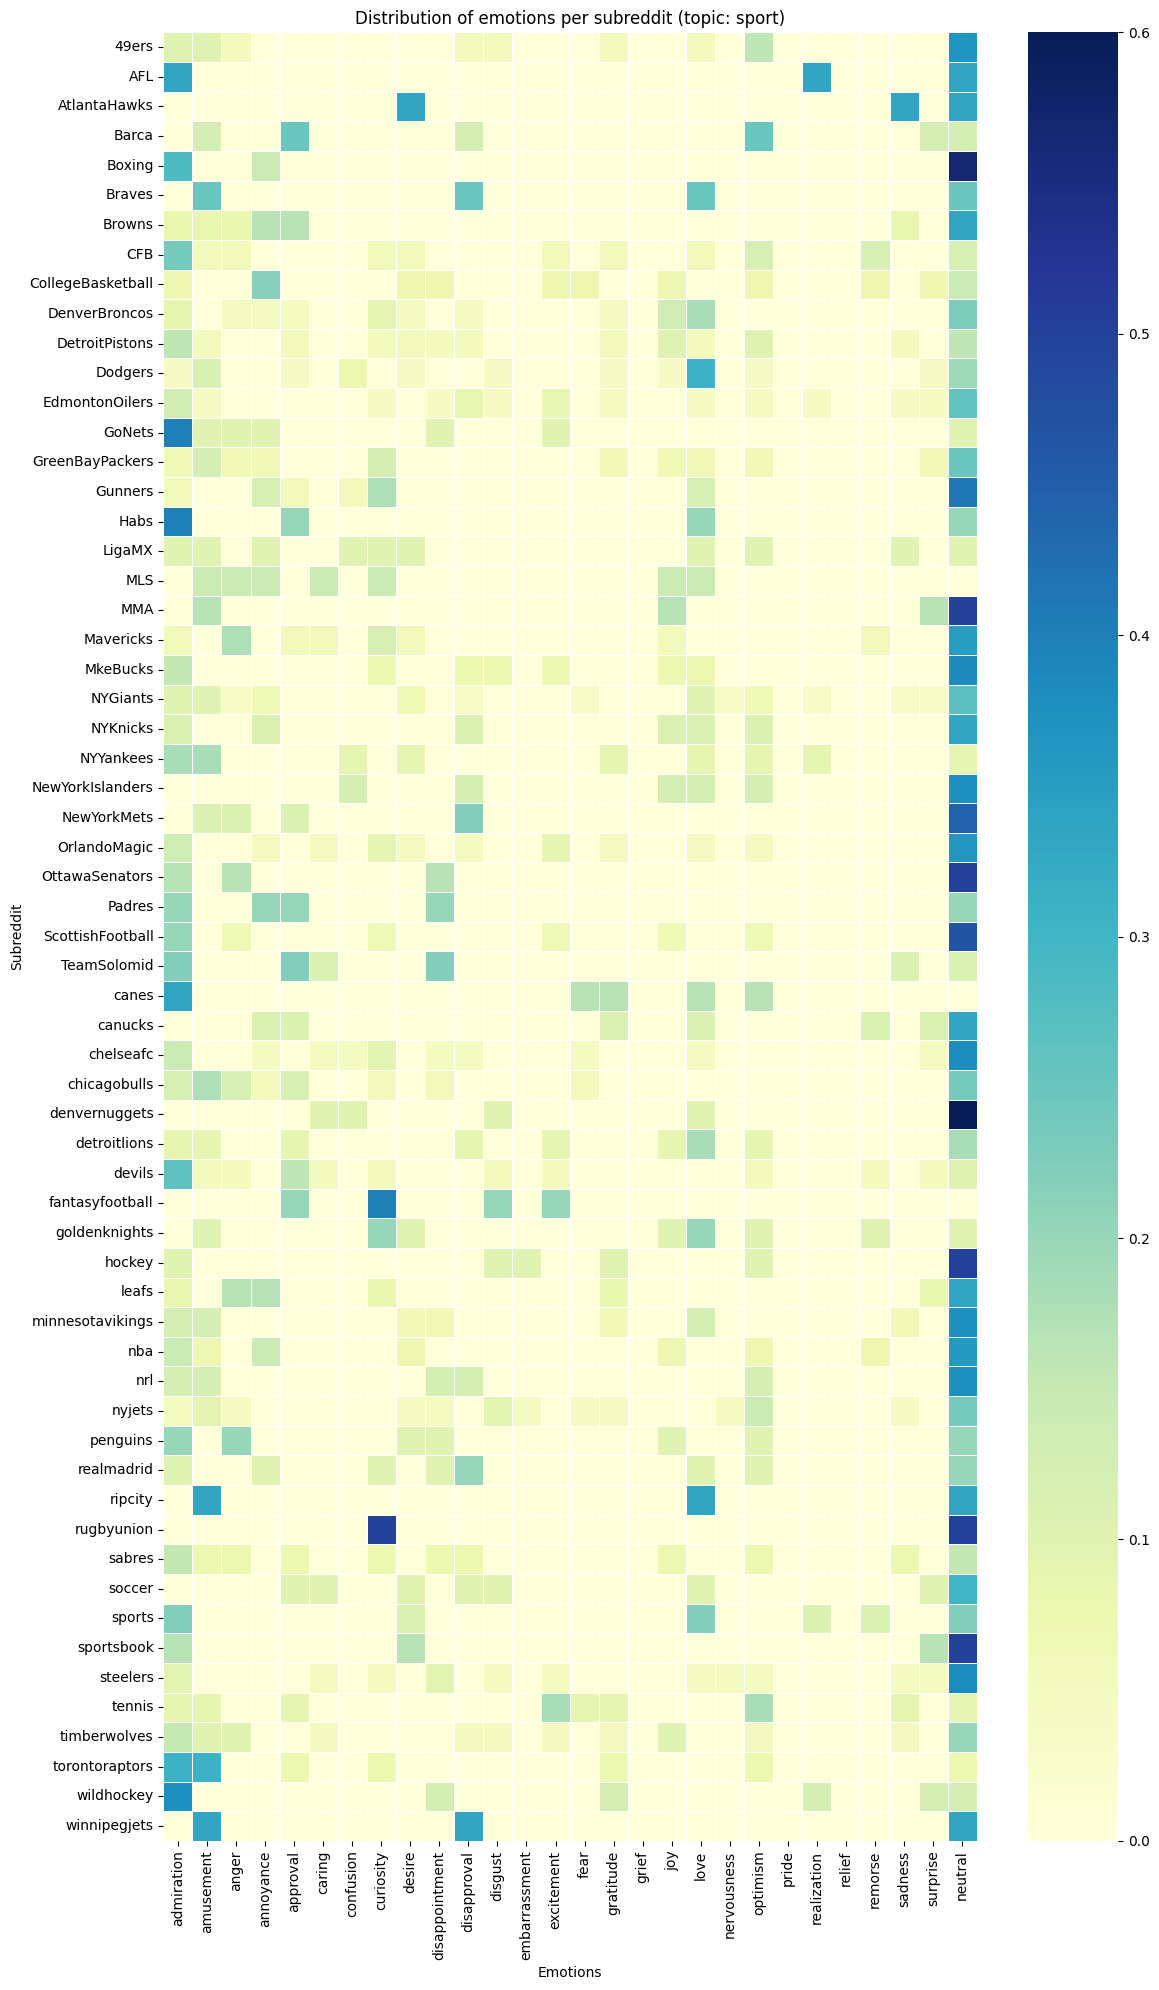

In [85]:
plot_heatmap(sport, "sport")

#### Love

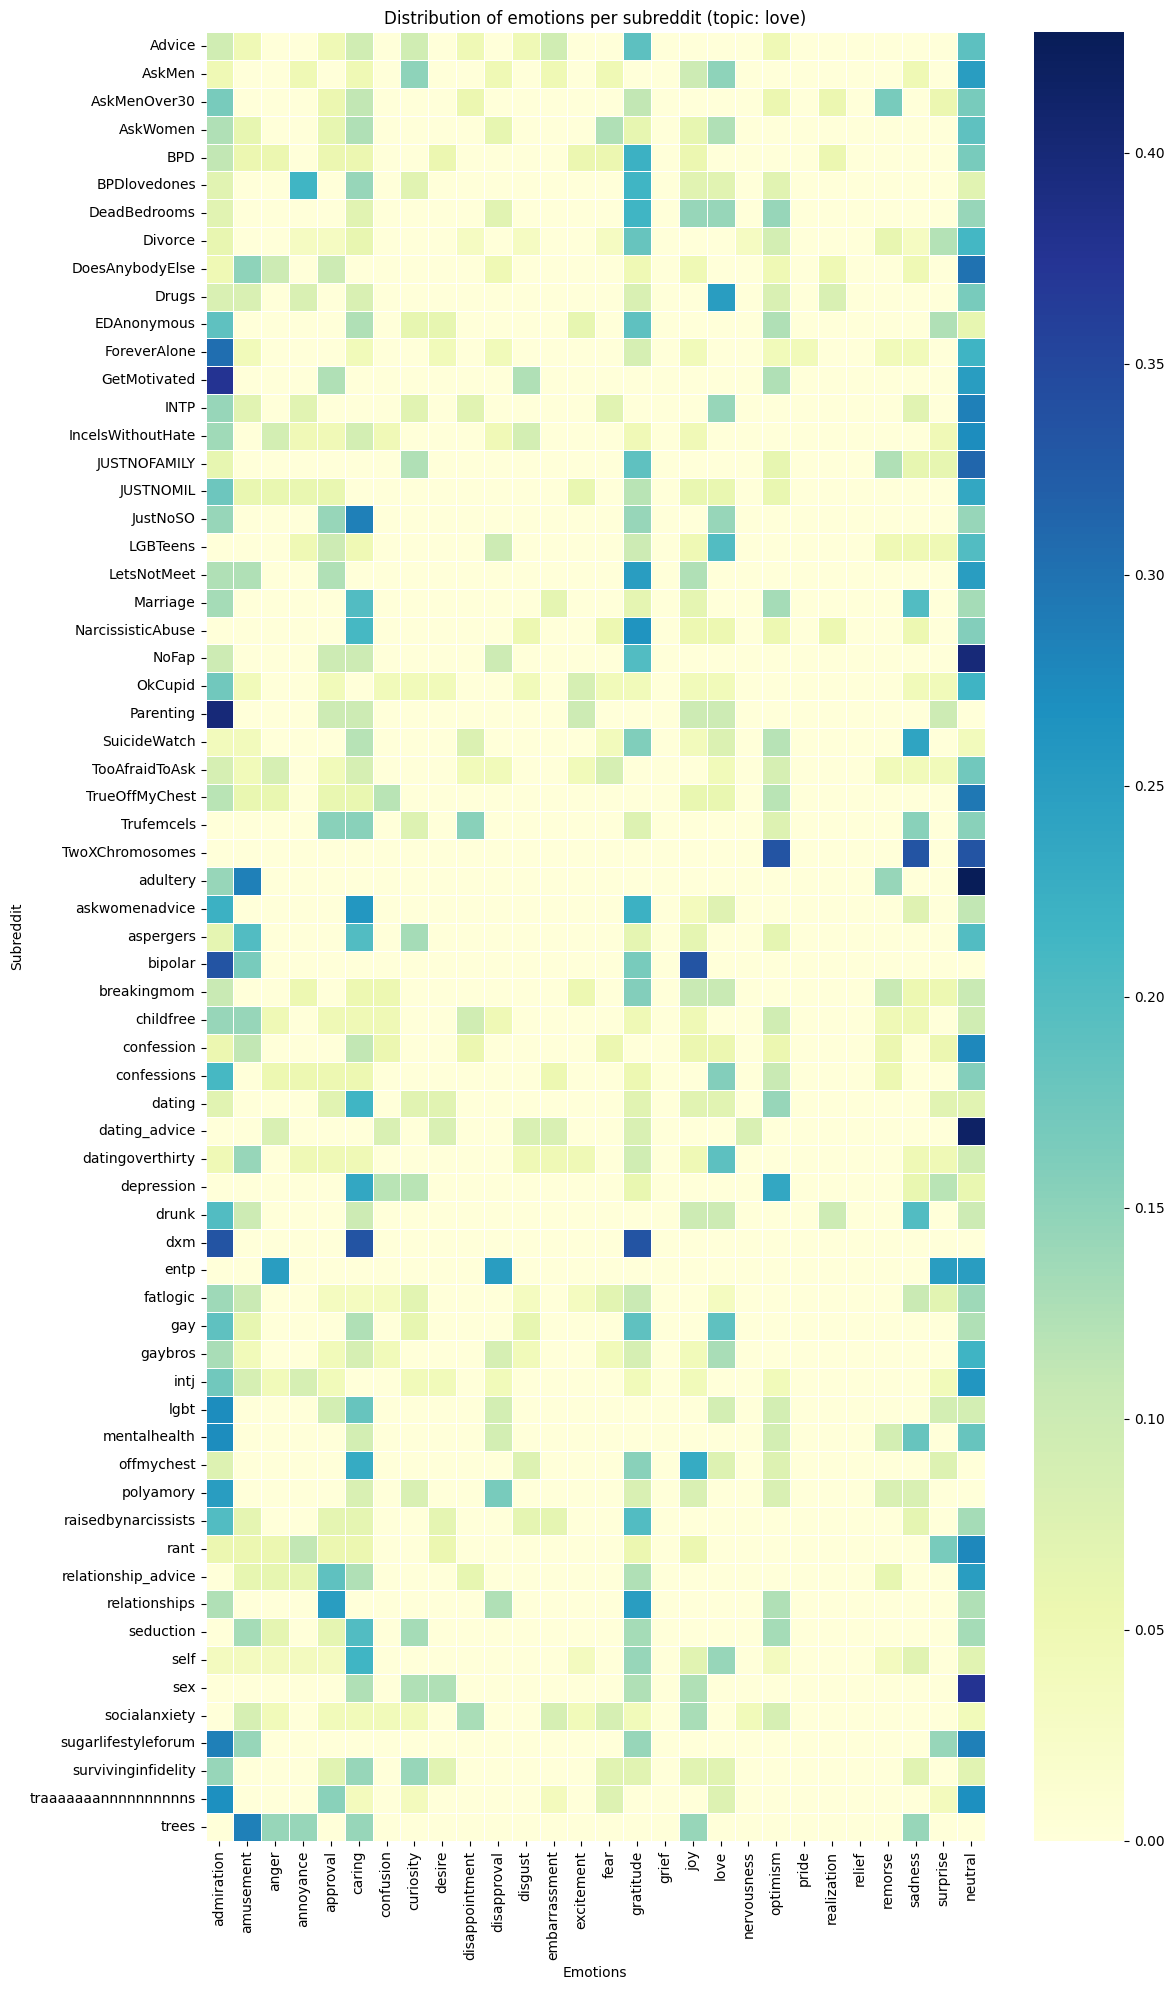

In [86]:
plot_heatmap(love, "love")

#### Humor

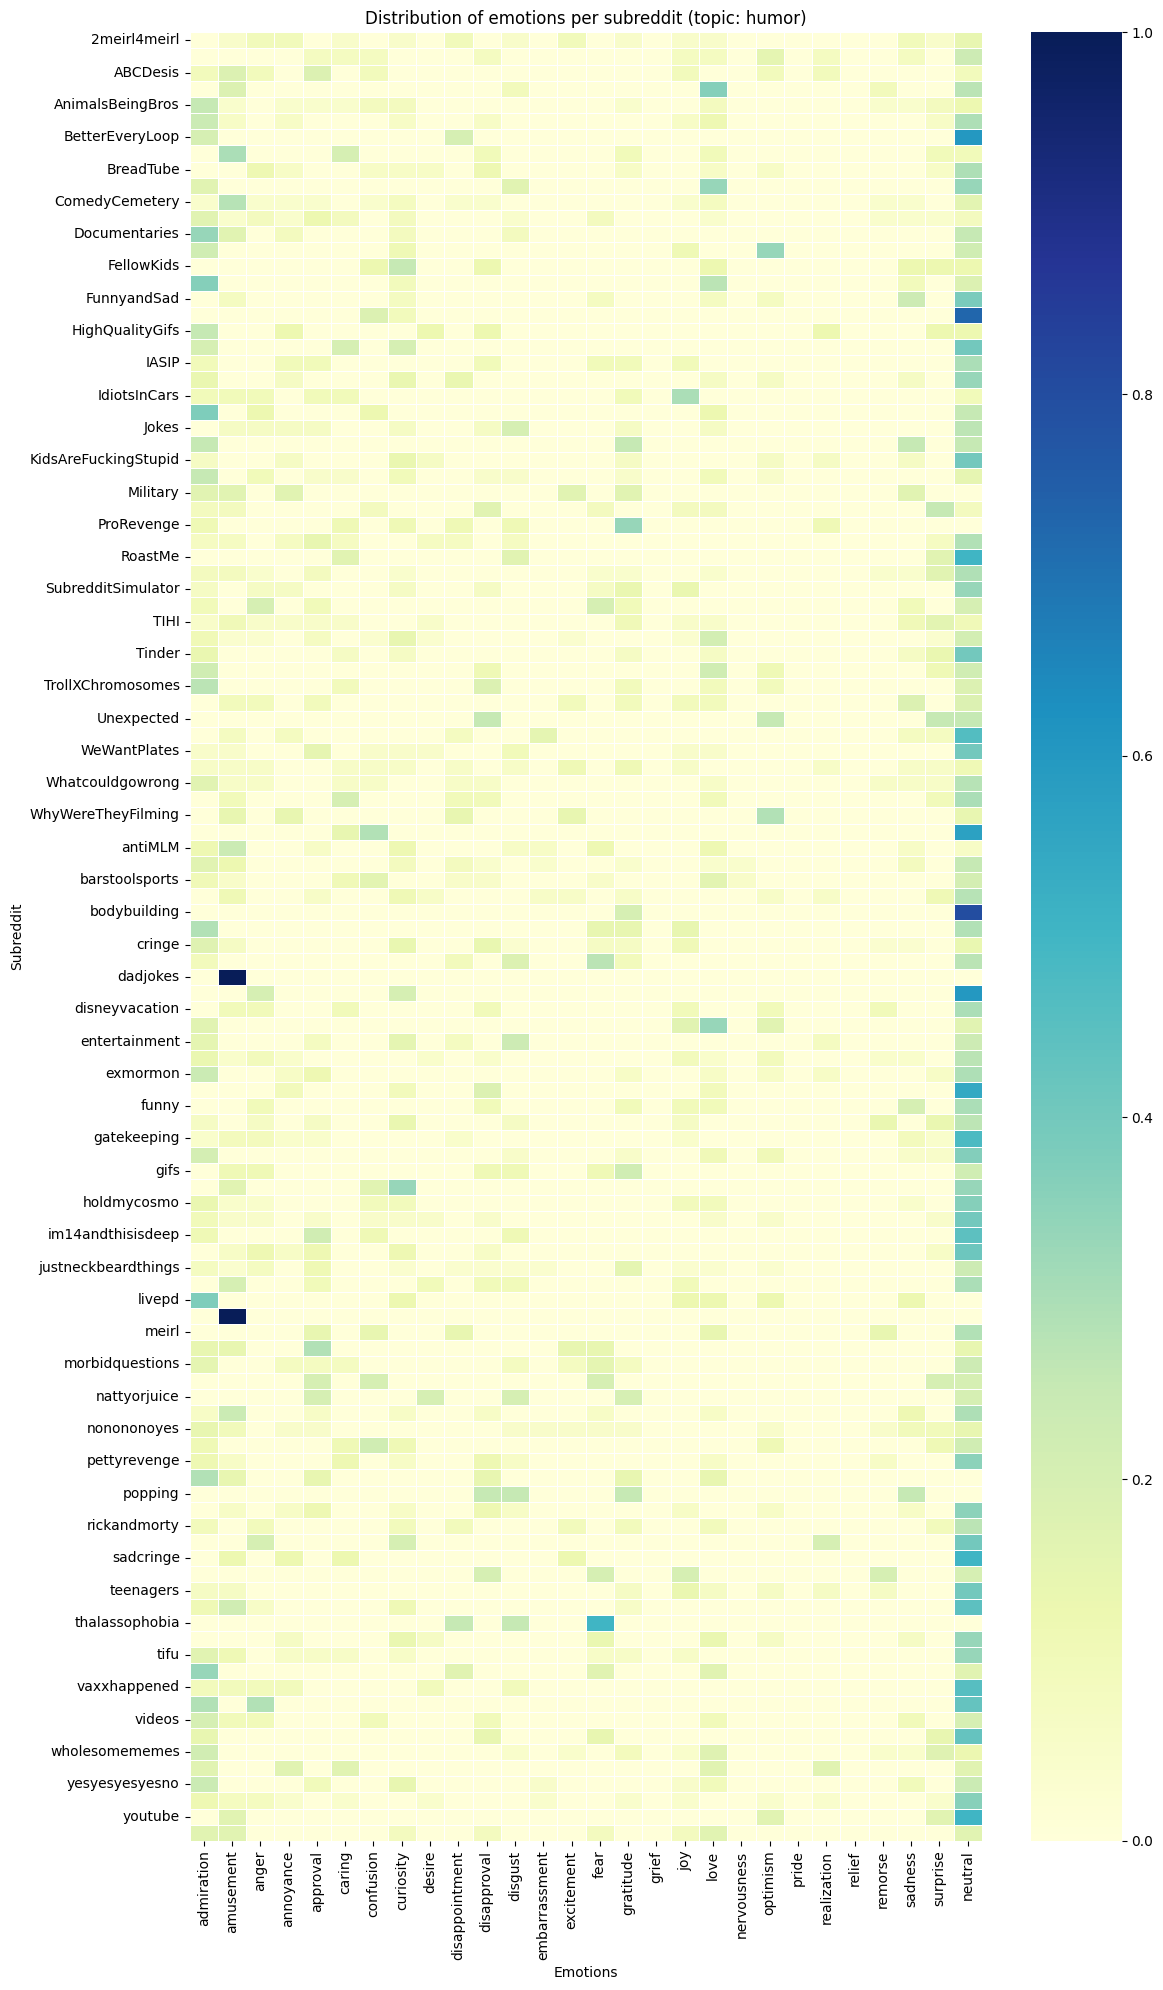

In [87]:
plot_heatmap(humor, "humor")

#### Other

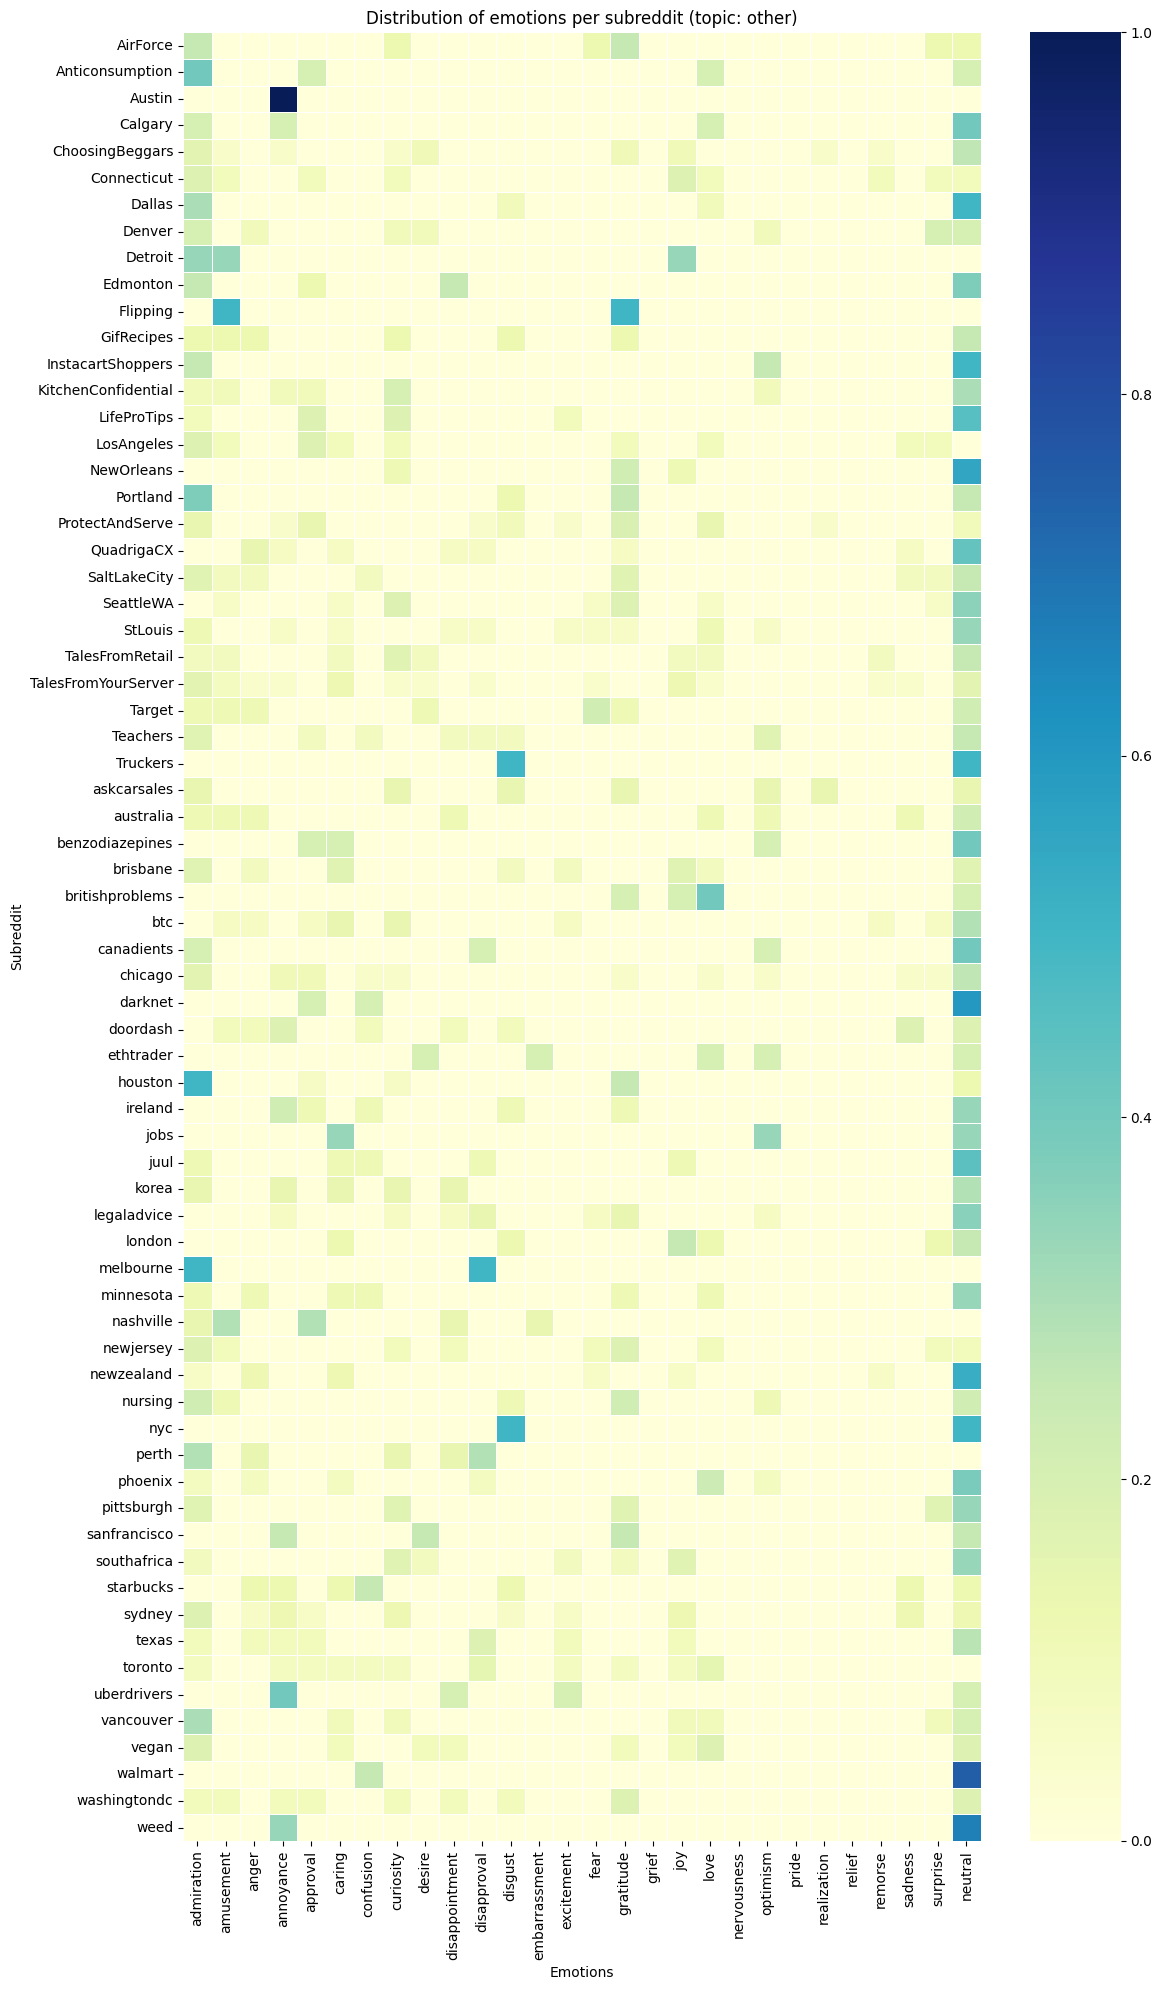

In [88]:
plot_heatmap(other, "other")